Install bycycle if you don't have it

In [14]:
!git clone https://github.com/bycycle-tools/bycycle
pip install '/Users/naomimiller/Documents/thesis_jhub/bycycle'

fatal: destination path 'bycycle' already exists and is not an empty directory.


In [6]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat,whosmat
import os.path
from scipy.stats import ttest_rel,ttest_1samp, ttest_ind, wilcoxon, kruskal,spearmanr,mannwhitneyu,sem

from neurodsp.sim import sim_combined
from bycycle.group import compute_features_3d
from bycycle.plts import plot_feature_categorical,plot_burst_detect_summary
from bycycle.utils import flatten_dfs

from tqdm import tqdm

Below: essential function to load in segmented data from beapp (already ica processed). Data should be in 3D form: channel by segment by timepoint, multiple participants should be in a folder. Organizes data and runs it through bycycle function from cole/voytek lab

In [7]:
import glob


def run_a_group(path_name,only_bursts=0,freq_range=(8,12)):
    
    """organizes segemented eeg data and runs it through the main bycycle function from cole/voytek lab

    Parameters
    ----------
    -path_name: string, the folder of participants' .mat files from BEAPP
    -only_bursts: bool, default: False
        whether to only account for cycles determined as "bursts" in determining average bycycle measures 

    Returns
    -------
    participant_avg : array of tuples w/ each participant's net type & bycycle average measures across time

    Notes
    -----
    -user should set thresholds for what is considered a burst in the "thresholds" variable
        currently set to amp_fraction_threshold=0., amp_consistency_threshold=.5, #using medians
                  period_consistency_threshold=.5, monotonicity_threshold=.5,
                  min_n_cycles=3
    -user should also set frequency band in compute_features_3d function call 
        currently alpha : 8-12 Hz
    -function to run a group of participants' segmented data through bycycle. 
     each participant's data MUST be in 3D form: channel by segment by timepoint
     -the path_name MUST be a folder of EEG .mat files that have been preprocessed and segmented in BEAPP
     -see https://github.com/lcnbeapp/beapp for more info
    """
        
    np.set_printoptions(threshold=np.inf)
    path = path_name
    files = [f for f in glob.glob(path + "**/*.mat", recursive=True)]
    fs = 250
    participant_avg={};

    for f in files:
        #initializing for average data for this participant
        name=os.path.basename(f).split('.mat')[0] #just participant #

        data=loadmat(f)
        #had to do this to be able to check by channel, will figure out mapping later
        eeg_data=data['eeg_w'][0][0]
        electrode_idx= data['file_proc_info']['net_10_20_elecs'][0][0][0]-1 #matlab to python idx
        netName=data['file_proc_info']['net_typ'][0][0][0][0][0]
        
        eeg_data=eeg_data[electrode_idx,:,:] #just 10_20 electrodes
        eeg_data=eeg_data.swapaxes(1,2) #channel by segment by timepoint
        #eeg_data.shape
        n_channels=len(eeg_data)
        n_epochs=len(eeg_data[0])

        thresholds = dict(amp_fraction_threshold=0., amp_consistency_threshold=.5, #using medians
                  period_consistency_threshold=.5, monotonicity_threshold=.5,
                  min_n_cycles=3)

        compute_kwargs = {'burst_method': 'cycles', 'threshold_kwargs': thresholds}

        dfs_rest = compute_features_3d(eeg_data, fs, freq_range, axis=0,
                                   compute_features_kwargs=compute_kwargs)

         #adding info about epochs and channels for organizing
        epoch_labels = ["Segment{ep_idx}".format(ep_idx=ep_idx) for ch_idx in range(n_channels) for ep_idx in range(n_epochs)]
        df_rest = flatten_dfs(dfs_rest, epoch_labels, 'Epoch')
    

        ch_labels = ["CH{ch_idx}".format(ch_idx=ch_idx+1) for ch_idx in electrode_idx for ep_idx in range(n_epochs)]
        df_channels = flatten_dfs(dfs_rest, ch_labels, 'Channel')
        
        #only keep cycles that are part of bursts
        if only_bursts==1:   
            df_channels=df_channels[df_channels['is_burst']==True]

        grouped_df_channels=df_channels.groupby('Channel')
        mean_df=grouped_df_channels.mean()
        #tuple
        participant_avg[name]=(netName,mean_df)      #  print(control_participant_avg.keys())
    return participant_avg #


Use below code as templates to run the groups' data in different frequency bands and save the tuples for later loading (to save time of reloading each folder of participants)

In [32]:
#GAMMA
#just bursts
control_participant_avg_1=run_a_group('/Users/naomimiller/Documents/thesis_jhub/all_participants/control_participants',only_bursts=1,freq_range=(30,55))
pms_participant_avg_1=run_a_group('/Users/naomimiller/Documents/thesis_jhub/all_participants/pms_participants',only_bursts=1,freq_range=(30,55))

#all cycles
control_participant_avg_2=run_a_group('/Users/naomimiller/Documents/thesis_jhub/all_participants/control_participants',only_bursts=0,freq_range=(30,55))
pms_participant_avg_2=run_a_group('/Users/naomimiller/Documents/thesis_jhub/all_participants/pms_participants',only_bursts=0,freq_range=(30,55))

#save the files
with open('controls_gamma_burst.pickle', 'wb') as file:
    pickle.dump(control_participant_avg_1,file)
with open('pms_gamma_burst.pickle', 'wb') as file:
    pickle.dump(pms_participant_avg_1,file)
    
with open('controls_gamma_all_cycle.pickle', 'wb') as file:
    pickle.dump(control_participant_avg_2,file)
with open('pms_gamma_all_cycle.pickle', 'wb') as file:
    pickle.dump(pms_participant_avg_2,file)

100%|██████████| 23/23 [09:43<00:00, 25.38s/it]


In [39]:
#BETA
#just bursts
control_participant_avg_1=run_a_group('/Users/naomimiller/Documents/thesis_jhub/all_participants/control_participants',only_bursts=1,freq_range=(13,30))
pms_participant_avg_1=run_a_group('/Users/naomimiller/Documents/thesis_jhub/all_participants/pms_participants',only_bursts=1,freq_range=(13,30))

#all cycles
control_participant_avg_2=run_a_group('/Users/naomimiller/Documents/thesis_jhub/all_participants/control_participants',only_bursts=0,freq_range=(13,30))
pms_participant_avg_2=run_a_group('/Users/naomimiller/Documents/thesis_jhub/all_participants/pms_participants',only_bursts=0,freq_range=(13,30))

#save the files
with open('controls_beta_burst.pickle', 'wb') as file:
    pickle.dump(control_participant_avg_1,file)
with open('pms_beta_burst.pickle', 'wb') as file:
    pickle.dump(pms_participant_avg_1,file)
    
with open('controls_beta_all_cycle.pickle', 'wb') as file:
    pickle.dump(control_participant_avg_2,file)
with open('pms_beta_all_cycle.pickle', 'wb') as file:
    pickle.dump(pms_participant_avg_2,file)

100%|██████████| 23/23 [05:00<00:00, 13.05s/it]


In [3]:
#ALPHA
#just bursts
control_participant_avg_1=run_a_group('/Users/naomimiller/Documents/thesis_jhub/all_participants/control_participants',only_bursts=1,freq_range=(8,12))
pms_participant_avg_1=run_a_group('/Users/naomimiller/Documents/thesis_jhub/all_participants/pms_participants',only_bursts=1,freq_range=(8,12))

#all cycles
control_participant_avg_2=run_a_group('/Users/naomimiller/Documents/thesis_jhub/all_participants/control_participants',only_bursts=0,freq_range=(8,12))
pms_participant_avg_2=run_a_group('/Users/naomimiller/Documents/thesis_jhub/all_participants/pms_participants',only_bursts=0,freq_range=(8,12))

#save the files
with open('/Users/naomimiller/Documents/thesis_jhub/new_alpha_data/controls_alpha_burst.pickle', 'wb') as file:
    pickle.dump(control_participant_avg_1,file)
with open('/Users/naomimiller/Documents/thesis_jhub/new_alpha_data/pms_alpha_burst.pickle', 'wb') as file:
    pickle.dump(pms_participant_avg_1,file)
    
with open('/Users/naomimiller/Documents/thesis_jhub/new_alpha_data/controls_alpha_all_cycle.pickle', 'wb') as file:
    pickle.dump(control_participant_avg_2,file)
with open('/Users/naomimiller/Documents/thesis_jhub/new_alpha_data/pms_alpha_all_cycle.pickle', 'wb') as file:
    pickle.dump(pms_participant_avg_2,file)

KeyError: 'eeg_w'

Use below code as a template to load in a saved tuple (change name if needed)

In [7]:
#load pre-run tuples from run_a_group (with bursts and without)
#ALPHA
with open('/Users/naomimiller/Documents/thesis_jhub/new_alpha_data/controls_alpha_all_cycle.pickle', "rb" ) as f:
    control = pickle.load(f)
with open('/Users/naomimiller/Documents/thesis_jhub/new_alpha_data/pms_alpha_all_cycle.pickle', "rb" ) as f:
    pms = pickle.load(f)
    
with open('/Users/naomimiller/Documents/thesis_jhub/new_alpha_data/controls_alpha_burst.pickle', "rb" ) as f:
    control_bursts = pickle.load(f)
with open('/Users/naomimiller/Documents/thesis_jhub/new_alpha_data/pms_alpha_burst.pickle', "rb" ) as f:
    pms_bursts = pickle.load(f)  

FUNCTIONS FOR STATISTICAL PROCESSING

In [11]:
#Comparing two groups on certain measures, with t test
#input all participant, all channel data for pms and controls
#input channel to compare and what measure

def map_channel(net_type, ch_name):
    """maps channels to bio semi or hydrocel 10-20 electrodes

    Parameters
    ----------
    -net_type: string, either 'HydroCel GSN 128 1.0' or 'Biosemi_32'
    -ch_name: string, must be one of keys in name_dict below
       
    Returns
    -------
    -int, the channel number associated with the channel name for that net type 
    """
    
    name_dict={'FP1':[22,1],'FP2':[9,30],
               'F7':[33,3],'F3':[24,4],'Fz':[11,31],'F4':[124,27],'F8':[122,28],
               'T3':[45,7],'C3':[36,8],'C4':[104,23],'T4':[108,24],
               'T5':[58,11],'P3':[52,12],'Pz':[62,13],'P4':[92,19],'T6':[96,20],
               'O1':[70,15],'O2':[83,17]}
    
    if ch_name in name_dict.keys():
        if net_type == 'HydroCel GSN 128 1.0':
            return f'CH{name_dict[ch_name][0]}'
        else:
            return f'CH{name_dict[ch_name][1]}'
    return ch_name


def loop_through_dict(this_dict,feature,ch_name):
    """loops through the tuple of type like that returned from run_a_group to find one 
    data point from each participant for a specific measure and channel name 

    Parameters
    ----------
    -this_dict: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -ch_name: string, must be one of keys in name_dict 
    -measure: string, must be one of the 23 bycycle measures, such as amp_fraction or time_rdsym
       
    Returns
    -------
    -list of values, one per participant in the tuple
    """
    
    df_measures=[]
    
    for p in this_dict.keys():        
        df=pd.DataFrame.from_dict(this_dict[p][1][feature])
        true_channel = ch_name
        net_type = this_dict[p][0]
        
        # Update true channel based on the name_dict so we can map between netType channel names      
        true_channel = map_channel(net_type,ch_name)
        df_measures.append(df[feature][true_channel])
    return df_measures
    
    

def control_v_pms(control_dict, pms_dict, ch_name, feature): 
    """runs t test on a channel and a measure bw pms and control groups
    
    Parameters
    ----------
    -control_dict: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -pms_dict: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -ch_name: string, must be one of keys in name_dict 
    -measure: string, must be one of the 23 bycycle measures, such as amp_fraction or time_rdsym
       
    Returns
    -------
    -KruskalResult, a statistic and p-value
    
    Notes
    ------
    -requires scipy.stats kruskal, or whatever t test is desirable
    """
    #loop through control avg dicts
    control_measures=loop_through_dict(control_dict,feature,ch_name) 
    #loop through pms avg dicts   
    pms_measures=loop_through_dict(pms_dict,feature,ch_name)  
    
    #kruskal wallis test 
    t=kruskal(pms_measures,control_measures)
    return t

def control_minus_pms(control_dict, pms_dict, ch_name, feature): 
    """finds avg differences in a channel and a measure bw pms and control groups
    
    Parameters
    ----------
    -control_dict: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -pms_dict: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -ch_name: string, must be one of keys in name_dict 
    -measure: string, must be one of the 23 bycycle measures, such as amp_fraction or time_rdsym
       
    Returns
    -------
    -mean: a float that represents the difference bw averages of two groups
    
    Notes
    ------
    -requires scipy.stats kruskal, or whatever t test is desirable
    """
    #loop through control avg dicts
    control_measures=loop_through_dict(control_dict,feature,ch_name) 
    #loop through pms avg dicts   
    pms_measures=loop_through_dict(pms_dict,feature,ch_name)  
    
    #kruskal wallis test 
    mean=np.mean(pms_measures)-np.mean(control_measures)
    return mean

def control_v_pms_plot(control_dict, pms_dict, ch_name, feature):
    import seaborn as sns
    #loop through control avg dicts
    control_measures=loop_through_dict(control_dict,feature,ch_name) 
    #loop through pms avg dicts   
    pms_measures=loop_through_dict(pms_dict,feature,ch_name)  
    
    df = pd.DataFrame()
    df['PMS'] = pd.Series(pms_measures)
    df['TD'] = pd.Series(control_measures)
    
    f=plt.figure()
    fig=sns.catplot(data=df,linewidth=1)
    sns.boxplot(data=df, whis=np.inf)
    fig.set_axis_labels("Group", f'{feature} in {ch_name}')
    plt.title(f'Individual {feature} in {ch_name} by Group')
    difference= control_minus_pms(control_dict, pms_dict, ch_name, feature)
    kruskal=control_v_pms(control_dict, pms_dict, ch_name, feature)
    plt.text(0.5,.3, f'Difference in means={difference:.3f}\n Kruskal-Wallace Result= {kruskal.statistic:.3f} (p={kruskal.pvalue:.3f})' , ha='left', va='top',transform=f.transFigure)


def one_channel_one_measure_all_participants(control_dict, pms_dict, ch_name, measure):
    """collects one measure in one channel across all participants, pms & control groups
    
    Parameters
    ----------
    -control_dict: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -pms_dict: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -ch_name: string, must be one of keys in name_dict 
    -measure: string, must be one of the 23 bycycle measures, such as amp_fraction or time_rdsym
       
    Returns
    -------
    -pandas dataframe with 2 columns: participant and the measure of choice in a channel of choice
    
    """
    one_measure=[]
    #loop through participants in control avg dicts
    for p in control_dict.keys(): 
        name=f'{p}.mat'
        df=pd.DataFrame.from_dict(control_dict[p][1][measure])
        true_channel = ch_name
        net_type = control_dict[p][0]
       
        # Update true channel based on the name_dict so we can map between netType channel names      
        true_channel = map_channel(net_type,ch_name)
        one_measure.append([name,df[measure][true_channel]]) 
        
        
    #loop through participants in pms avg dicts   
    for j in pms_dict.keys(): 
        name=f'{j}.mat'
        df=pd.DataFrame.from_dict(pms_dict[j][1][measure])
        true_channel = ch_name
        net_type = pms_dict[j][0]       
        # Update true channel based on the name_dict so we can map between netType channel names
        true_channel = map_channel(net_type,ch_name)                              
        one_measure.append([name,df[measure][true_channel]])
        
    
    one_measure=pd.DataFrame(one_measure,columns=['filenames',f'{measure}'])
    return one_measure


Examples

In [187]:
control_v_pms(control,pms,'C3','period_consistency')


KruskalResult(statistic=14.169182169182164, pvalue=0.00016708485062528892)

<Figure size 432x288 with 0 Axes>

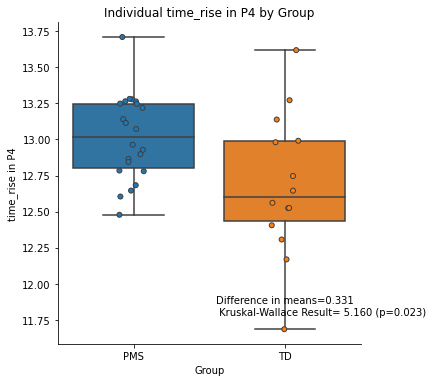

In [61]:
control_v_pms_plot(control_bursts,pms_bursts,'P4','time_rise')

#print(control_minus_pms(control,pms,'Pz','time_rdsym'))

run ttests between the two groups on all measures and find the significant differences (change test its t test now)

In [10]:
def find_all_significant(control_tuple, pms_tuple, columns='columns2'):
    """run ttests between the two groups on all measures and find the significant differences 
      also return all comparisons (not just the significant ones)
    Parameters
    ----------
    -control_tuple: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -pms_tuple: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -columns=string, columns1 or columns2, default=columns2
        they are the same, but columns2 should be used if the tuples were processed in run_a_group with only_bursts=1
        
    Returns
    -------
    -tuple with two pandas dataframes, columns= 'channel','measure','test stat','p val'
        one for the kruskal result between groups for every channel and every measure = 414 rows
        one for only the significant p<.05 kruskal results
    """
    test_results=[]
    #below is the mapping for channel names and numbers in 2 different types of nets
    name_dict={'FP1':[22,1],'FP2':[9,30],
               'F7':[33,3],'F3':[24,4],'Fz':[11,31],'F4':[124,27],'F8':[122,28],
               'T3':[45,7],'C3':[36,8],'C4':[104,23],'T4':[108,24],
               'T5':[58,11],'P3':[52,12],'Pz':[62,13],'P4':[92,19],'T6':[96,20],
               'O1':[70,15],'O2':[83,17]}
    significant=[]

    columns1=['amp_fraction', 'amp_consistency', 'period_consistency', 'monotonicity',
       'period', 'time_peak', 'time_trough', 'volt_peak', 'volt_trough',
       'time_decay', 'time_rise', 'volt_decay', 'volt_rise', 'volt_amp',
       'time_rdsym', 'time_ptsym', 'band_amp', 'sample_peak',
       'sample_last_zerox_decay', 'sample_zerox_decay', 'sample_zerox_rise',
       'sample_last_trough', 'sample_next_trough', 'is_burst']

    #same as above but without the "is_burst" measure
    columns2= ['amp_fraction', 'amp_consistency', 'period_consistency', 'monotonicity',
       'period', 'time_peak', 'time_trough', 'volt_peak', 'volt_trough',
       'time_decay', 'time_rise', 'volt_decay', 'volt_rise', 'volt_amp',
       'time_rdsym', 'time_ptsym', 'band_amp', 'sample_peak',
       'sample_last_zerox_decay', 'sample_zerox_decay', 'sample_zerox_rise',
       'sample_last_trough', 'sample_next_trough']
    
    if columns=='columns1':
        columns=columns1
    else:
        columns=columns2
        
    #run through all channels
    for ch in name_dict.keys(): 
        for measure in columns: #loop through each measure:
            #run kruskal wallis test bw two groups
            test=control_v_pms(control_tuple, pms_tuple, ch_name=ch,feature=measure)
           
            #save significant comparisons (a channel and measure that was difft between groups)
            if test.pvalue<=.05:
                significant.append([ch,measure,test.statistic,test.pvalue])#all significant test results
            
            #save all comparisons
            test_results.append([ch,measure,test.statistic,test.pvalue])#all test results
    
    all_pvals=pd.DataFrame(test_results,columns=['channel','measure','test stat','p val']) 
    all_sig=pd.DataFrame(significant,columns=['channel','measure','test stat','p val'])
    return all_pvals,all_sig
    #return pd.DataFrame(test_results)


def find_all_differences(control_tuple, pms_tuple, columns='columns2'):
    """finds differences between the two groups on all measures 
    Parameters
    ----------
    -control_tuple: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -pms_tuple: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -columns=string, columns1 or columns2, default=columns2
        they are the same, but columns2 should be used if the tuples were processed in run_a_group with only_bursts=1
        
    Returns
    -------
    -tuple with a pandas dataframes, columns= 'channel','measure','difference'
    """
    test_results=[]
    name_dict={'FP1':[22,1],'FP2':[9,30],
               'F7':[33,3],'F3':[24,4],'Fz':[11,31],'F4':[124,27],'F8':[122,28],
               'T3':[45,7],'C3':[36,8],'C4':[104,23],'T4':[108,24],
               'T5':[58,11],'P3':[52,12],'Pz':[62,13],'P4':[92,19],'T6':[96,20],
               'O1':[70,15],'O2':[83,17]}
    significant=[]

    columns1=['amp_fraction', 'amp_consistency', 'period_consistency', 'monotonicity',
       'period', 'time_peak', 'time_trough', 'volt_peak', 'volt_trough',
       'time_decay', 'time_rise', 'volt_decay', 'volt_rise', 'volt_amp',
       'time_rdsym', 'time_ptsym', 'band_amp', 'sample_peak',
       'sample_last_zerox_decay', 'sample_zerox_decay', 'sample_zerox_rise',
       'sample_last_trough', 'sample_next_trough', 'is_burst']

    #same as above but without the "is_burst" measure
    columns2= ['amp_fraction', 'amp_consistency', 'period_consistency', 'monotonicity',
       'period', 'time_peak', 'time_trough', 'volt_peak', 'volt_trough',
       'time_decay', 'time_rise', 'volt_decay', 'volt_rise', 'volt_amp',
       'time_rdsym', 'time_ptsym', 'band_amp', 'sample_peak',
       'sample_last_zerox_decay', 'sample_zerox_decay', 'sample_zerox_rise',
       'sample_last_trough', 'sample_next_trough']
    
    if columns=='columns1':
        columns=columns1
    else:
        columns=columns2
        
    #run through all channels
    for ch in name_dict.keys(): 
        for measure in columns: #loop through each measure:
            #print(ch,measure)
            #run kruskal wallis test bw two groups
            test=control_minus_pms(control_tuple, pms_tuple, ch_name=ch,feature=measure)
           
            #save all comparisons
            test_results.append([ch,measure,test])#all test results
    
    all_differences=pd.DataFrame(test_results,columns=['channel','measure','difference']) 
    return all_differences
    #return pd.DataFrame(test_results)



In [20]:
d=find_all_significant(control_bursts,pms_bursts)
display(d[0])

p_under_05=d[1].sort_values(by='measure')
display(p_under_05.sort_values('channel'))
p_under_05.to_csv('new_alpha_data/control_v_pms_kruskal_burstsonly_p.05.csv')

,channel,measure,test stat,p val
0,FP1,amp_fraction,0.304317,0.581188
1,FP1,amp_consistency,0.421200,0.516339
2,FP1,period_consistency,0.206388,0.649613
3,FP1,monotonicity,0.151632,0.696980
4,FP1,period,0.127413,0.721129
...,...,...,...,...
409,O2,sample_last_zerox_decay,0.000000,1.000000
410,O2,sample_zerox_decay,0.004212,0.948254
411,O2,sample_zerox_rise,0.009477,0.922449
412,O2,sample_last_trough,0.001053,0.974113


,channel,measure,test stat,p val
1,C3,period,5.766234,0.016337
0,C3,period_consistency,10.113022,0.001472
2,C3,time_peak,4.586873,0.032218
3,C3,time_trough,5.308178,0.021226
4,C3,time_rise,6.908740,0.008578
6,C4,time_trough,5.013338,0.025153
7,C4,time_rise,7.607933,0.005811
5,C4,period,4.047736,0.044231
8,C4,time_rdsym,4.869077,0.027342
19,O1,time_rise,7.607933,0.005811


In [17]:
c=find_all_significant(control,pms)
display(c[0])

p=c[1].sort_values(by='measure')
display(p.sort_values('measure'))
#p_under_05.to_csv('new_alpha_data/control_v_pms_kruskal_burstsonly_p.05.csv')

,channel,measure,test stat,p val
0,FP1,amp_fraction,0.009477,0.922449
1,FP1,amp_consistency,0.421200,0.516339
2,FP1,period_consistency,3.790804,0.051535
3,FP1,monotonicity,0.177957,0.673135
4,FP1,period,0.127413,0.721129
...,...,...,...,...
409,O2,sample_last_zerox_decay,0.016848,0.896725
410,O2,sample_zerox_decay,0.026325,0.871109
411,O2,sample_zerox_rise,0.037908,0.845628
412,O2,sample_last_trough,0.009477,0.922449


,channel,measure,test stat,p val
19,P3,amp_consistency,5.766234,0.016337
18,T4,monotonicity,8.529309,0.003495
30,O2,monotonicity,4.313092,0.037820
10,C3,period,4.586873,0.032218
0,F7,period_consistency,3.918217,0.047766
20,P3,period_consistency,4.047736,0.044231
9,C3,period_consistency,14.169182,0.000167
14,C4,period_consistency,7.254124,0.007074
6,F8,sample_last_trough,5.766234,0.016337
3,F8,sample_last_zerox_decay,5.458757,0.019470


In [145]:
realdiffs=find_all_differences(control,pms)
display(realdiffs[realdiffs['channel']=='C3'])

,channel,measure,difference
184,C3,amp_fraction,0.000072
185,C3,amp_consistency,-0.015057
186,C3,period_consistency,-0.015771
187,C3,monotonicity,0.005609
188,C3,period,0.383304
189,C3,time_peak,0.138892
190,C3,time_trough,0.244018
191,C3,volt_peak,-0.648529
192,C3,volt_trough,0.696430
193,C3,time_decay,0.032120


FDR CORRECTION ON P VALUES

In [11]:
from statsmodels.stats.multitest import fdrcorrection

#find all p vals for all comparisons 
all_pvals,all_sig=find_all_significant(control,pms,'columns2')

def fdr_correction_across_channels(all_pvals,significant_pval):
    """run fdr correction on sets of 23 bycycle p values, one channel at a time
   
    Parameters
    ----------
    -all_pvals: a dataframe of the type returned from find_all_signficant
        columns= 'channel','measure','test stat','p val'
    -significant_pval: p-value below which to reject the null hypothesis
    
    Returns
    -------
    -trues: pandas dataframe with only the measures deemed significant by fdr correction
        columns='channel','measure','test stat','p val', 'rejected', 'corrected p val' 
        
    Notes
    -----
    -fdr alpha threshold is set to .1 for exploratory analyses
    """
    
    columns=['amp_consistency', 'period_consistency', 'monotonicity',
           'period', 'time_peak', 'time_trough', 'volt_peak', 'volt_trough',
           'time_decay', 'time_rise', 'volt_decay', 'volt_rise', 'volt_amp',
           'time_rdsym', 'time_ptsym', 'band_amp', 'sample_peak',
           'sample_last_zerox_decay', 'sample_zerox_decay', 'sample_zerox_rise',
           'sample_last_trough', 'sample_next_trough']

    all_pvals=all_pvals.sort_values(by='measure')
    trues=pd.DataFrame() #initialize empty df

    #do fdr corrections measure by measure (across channels)
    for measure in columns:
        p_vals_this_channel=all_pvals[all_pvals['measure']==measure] #just pull out the parts of the df from this channel
        new_pval=fdrcorrection(p_vals_this_channel['p val'],alpha=significant_pval) #alpha=.1

        p_vals_this_channel['Rejected']=new_pval[0]
        p_vals_this_channel['corrected p val']=new_pval[1]

        #find all significant with new pvals
        if len(trues)==0:
            trues=p_vals_this_channel[p_vals_this_channel['Rejected']==True]    
        else:
            temp=p_vals_this_channel[p_vals_this_channel['Rejected']==True]    
            trues=trues.append(temp)
    return trues


In [29]:
#Find significant measures across all channels and measures using FDR
from statsmodels.stats.multitest import fdrcorrection


all_pvals,all_sig=find_all_significant(control,pms,'columns2')

def fdr_correction_across_measures(all_pvals,significant_pval):
    """run fdr correction on sets of 18 channel p values, one measure at a time
   
    Parameters
    ----------
    -all_pvals: a dataframe of the type returned from find_all_signficant
        columns= 'channel','measure','test stat','p val'
    -significant_pval: p-value below which to reject the null hypothesis
    
    Returns
    -------
    -trues: pandas dataframe with only the measures deemed significant by fdr correction
        columns='channel','measure','test stat','p val', 'rejected', 'corrected p val' 
        
    Notes
    -----
    -fdr alpha threshold is set to .1 for exploratory analyses
    """
    name_dict={'FP1':[22,1],'FP2':[9,30],
               'F7':[33,3],'F3':[24,4],'Fz':[11,31],'F4':[124,27],'F8':[122,28],
               'T3':[45,7],'C3':[36,8],'C4':[104,23],'T4':[108,24],
               'T5':[58,11],'P3':[52,12],'Pz':[62,13],'P4':[92,19],'T6':[96,20],
               'O1':[70,15],'O2':[83,17]}
    
    all_pvals=all_pvals.sort_values(by='channel')
    trues=pd.DataFrame()

    for channel in name_dict.keys():
        p_vals_this_channel=all_pvals[all_pvals['channel']==channel] #just pull out the parts of the df from this channel
        #display(p_vals_this_channel)
        new_pval=fdrcorrection(p_vals_this_channel['p val'],alpha=significant_pval)
        p_vals_this_channel['Rejected']=new_pval[0]
        p_vals_this_channel['corrected p val']=new_pval[1]


        #find all significant with new pvals
        if len(trues)==0:
            trues=p_vals_this_channel[p_vals_this_channel['Rejected']==True]    
        else:
            temp=p_vals_this_channel[p_vals_this_channel['Rejected']==True]    
            trues=trues.append(temp)
            
        return(trues)

In [142]:
fdr_correction_across_channels(all_pvals,.1)

,channel,measure,test stat,p val,Rejected,corrected p val
186,C3,period_consistency,14.169182,0.000167,True,0.003008
209,C4,period_consistency,7.254124,0.007074,True,0.063665
233,T4,monotonicity,8.529309,0.003495,True,0.062905
217,C4,time_rise,8.719902,0.003148,True,0.042443
309,Pz,time_rise,4.448929,0.034923,True,0.089802
332,P4,time_rise,4.448929,0.034923,True,0.089802
378,O1,time_rise,7.429975,0.006415,True,0.042443
401,O2,time_rise,5.159705,0.023117,True,0.083221
194,C3,time_rise,6.082134,0.013656,True,0.061450
286,P3,time_rise,7.254124,0.007074,True,0.042443


In [31]:

df2=find_all_significant(control_bursts,pms_bursts,'columns2')
df=fdr_correction_across_channels(df2[0],.1)
display(df.sort_values('measure'))
df.to_csv('control_v_pms_kruskal_p.05.csv')

,channel,measure,test stat,p val,Rejected,corrected p val
233,T4,monotonicity,8.529309,0.003495,True,0.062905
186,C3,period_consistency,10.113022,0.001472,True,0.026501
290,P3,time_rdsym,8.154440,0.004296,True,0.063665
382,O1,time_rdsym,7.254124,0.007074,True,0.063665
217,C4,time_rise,7.607933,0.005811,True,0.034867
309,Pz,time_rise,5.923131,0.014943,True,0.053796
332,P4,time_rise,5.159705,0.023117,True,0.059443
378,O1,time_rise,7.607933,0.005811,True,0.034867
401,O2,time_rise,5.159705,0.023117,True,0.059443
194,C3,time_rise,6.908740,0.008578,True,0.038599


In [35]:
df1.to_csv('control_v_pms_kruskal_p.05.csv')
df2.to_csv('control_v_pms_bursts_only_kruskal_p.05.csv')

Code to merge PMS_pac stats file and all the bycycle average measures for a channel for all participants

In [12]:
def merge_with_stats(control_dict,pms_dict,ch_name): 
    """merge the PMS_PAC_6_3_20 stats excel sheet with average bycycle measures
   
    Parameters
    ----------
    -control_dict: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -pms_dict: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -ch_name: string, must be one of keys in name_dict 
   
    Returns
    -------
    -pandas dataframe with rows for each participant, includes their demographic measures and the 23 bycycle average measures
    for one channel of choice
        174 columns total
    """
    
    xls=pd.read_excel('PMS_PAC_6_3_20.xls') #load pre-existing demographic excel sheet
    #removed amp_fraction
    columns=['amp_consistency', 'period_consistency', 'monotonicity',
           'period', 'time_peak', 'time_trough', 'volt_peak', 'volt_trough',
           'time_decay', 'time_rise', 'volt_decay', 'volt_rise', 'volt_amp',
           'time_rdsym', 'time_ptsym', 'band_amp', 'sample_peak',
           'sample_last_zerox_decay', 'sample_zerox_decay', 'sample_zerox_rise',
           'sample_last_trough', 'sample_next_trough', 'is_burst']

    first=one_channel_one_measure_all_participants(control_dict, pms_dict, ch_name,'amp_fraction')
    
    #loop through each measure, get the avg value in this channel for that measure
    for measure in columns: 
        this_measure=one_channel_one_measure_all_participants(control_dict, pms_dict, ch_name,measure)
        this_measure=pd.DataFrame(this_measure)
        #add it to the merged dataframe
        new_first=pd.merge(first,this_measure,on='filenames') 
        first=new_first
    merged=pd.merge(xls,first,how='inner',on='filenames') 
    return merged


Finding correlations bw measures

In [43]:
correlations.to_csv(f'C3_mutation_size_correlations')

In [16]:

def find_correlations(control_dict,pms_dict,control_bursts,pms_bursts,ch,correlation_measure):
    """calculate correlations bw a certain demographic and each bycycle measure in a channel
   
    Parameters
    ----------
    -control_dict: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -pms_dict: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe
    -control_bursts: tuple of participant data; keys=participants, values=net type and bycycle avg measures dataframe, only bursts
    -pms_bursts: tuple of participant data, keys=participants, values=net type and bycycle avg measures dataframe, only bursts
    -ch: string, must be one of channel keys in name_dict 
    -correlation_measure: string, must be one of the columns in the PMS_pac demographic excel sheet
   
    Returns
    -------
    -pandas dataframe with rows for each bycycle measure, includes the correlation stats between the demographic measure 
    and each bycycle measure, for just burst cycles and all cycles
        columns='Feature','Correlation','Pvalue','Correlation-burst only', and 'Pvalue-burst only'
    
    Notes
    -----
    -using the pre-loaded tuples control, pms, control_bursts,pms_bursts
    """ 
    columns=['amp_fraction', 'amp_consistency', 'period_consistency', 'monotonicity',
           'period', 'time_peak', 'time_trough', 'volt_peak', 'volt_trough',
           'time_decay', 'time_rise', 'volt_decay', 'volt_rise', 'volt_amp',
           'time_rdsym', 'time_ptsym', 'band_amp', 'sample_peak',
           'sample_last_zerox_decay', 'sample_zerox_decay', 'sample_zerox_rise',
           'sample_last_trough', 'sample_next_trough']

    #merge the averages for each participant for this channel without burst
    merged=merge_with_stats(control_dict,pms_dict,ch)
    #merge the averages for each participant for this channel with bursts
    merged_bursts=merge_with_stats(control_bursts,pms_bursts,ch)
   
    #FOR this channel
    #merged_bursts.to_csv(f'PMS_bycycle_burstsonly_merged_{ch}.csv')
   # merged.to_csv(f'PMS_bycycle_merged_{ch}.csv')
    
    #correlations for all cycles (not just bursts)
    correlations=[]
    for measure in columns:
        thiscorr=spearmanr(merged[measure],merged[correlation_measure],nan_policy='omit')
        correlations.append([measure,thiscorr.correlation,thiscorr.pvalue])
    correlations=pd.DataFrame(correlations,columns=['Feature','Correlation','Pvalue'])

    #only bursts
    correlations_bursts_only_p=[]
    correlations_bursts_only_corr=[]
    for measure in columns:
        thiscorr=spearmanr(merged_bursts[measure],merged_bursts[correlation_measure],nan_policy='omit')

        correlations_bursts_only_corr.append(thiscorr.correlation)
        correlations_bursts_only_p.append(thiscorr.pvalue)

    #merge with the original correlations df
    correlations['Correlation-burst only']=correlations_bursts_only_corr
    correlations['Pvalue-burst only']=correlations_bursts_only_p
    
    #save
    #correlations.to_csv(f'{ch}_{correlation_measure}_correlations')    
    return correlations

    

In [273]:
find_correlations(control,pms,control_bursts,pms_bursts,'P4','Hg19bpsize') 

,Feature,Correlation,Pvalue,Correlation-burst only,Pvalue-burst only
0,amp_fraction,-0.049020,0.851794,0.267157,0.299918
1,amp_consistency,-0.159314,0.541362,-0.031863,0.903377
2,period_consistency,-0.424020,0.089842,-0.345588,0.174252
3,monotonicity,-0.230392,0.373665,-0.237745,0.358171
4,period,0.257353,0.318668,0.335784,0.187614
5,time_peak,0.387255,0.124606,0.348039,0.171013
6,time_trough,0.144608,0.579755,0.267157,0.299918
7,volt_peak,0.203431,0.433555,0.223039,0.389523
8,volt_trough,-0.232843,0.368460,-0.264706,0.304542
9,time_decay,0.272059,0.290796,0.264706,0.304542


Graphing topoplots for correlation features across 10-20 channels

In [18]:
measure='time_rdsym'
phenotype_demographics=['SSP_Total','Hg19bpsize','ADOS_Comparison_Score']

def graph_topoplots_corr(phenotype_demographics,measure,bursts_only=1):
    """graph topoplots for a subset of demographics correlated with one measure
    
    Parameters
    ----------
    -phenotype_demographics: a list of strings, the demogrpahic measures to graph topoplots for
    -measure: string, must be one of the 23 bycycle measures to find correlations for
    -bursts_only: bool, default=True
        whether to account only for burst cycles or not
   
    """
    
    #must be in this order for plotting, corresponds to ch_x and ch_y below
    channels=['FP1', 'FP2', 'F7', 'F3', 'F4', 'F8', 'C3', 'C4', 'T5',
           'Pz','T6','O1', 'O2', 'T3', 'T4', 'P3', 'P4', 'Fz']

    for demographic in phenotype_demographics: #loop to plot each one
        corr_list=[]
        for ch in channels:   #loop through channels
            corre=find_correlations(control,pms,control_bursts,pms_bursts,ch,demographic) #find the correlation in this channel w this demographic
            if bursts_only==1:    
                tstat=(corre[corre['Feature']==measure]['Pvalue-burst only']).to_numpy() #get p value =strength of correlation
            else:
                tstat=(corre[corre['Feature']==measure]['Correlation']).to_numpy()
            corr_list.append(tstat)

        mini=-1
        maxi=1

        #scatter plot axis locations
        ch_x = [4,6,2.2,3.4,6.6,7.8,2.9,7.1,2.1,5,7.9,3.8,6.2,1.1,8.9,3.5,6.5,5]
        ch_y = [8.7,8.7,7.95,6.7,6.7,7.95,4.9,4.9,1.95,2.5,1.95,1,1,4.6,4.6,2.7,2.7,7.1]

        fig,ax = plt.subplots()
        
        #graph the scatter plot of p-values, s=2000 is point size
        im = ax.scatter(ch_x, ch_y,s=2000,c=corr_list,vmin=mini,vmax=maxi,cmap='seismic')

        #add labels
        i=0
        for x,y in zip(ch_x,ch_y):
            label= '%.2f'%corr_list[i]
            i+=1
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,30), # distance from text to points (x,y)
                     ha='center') 

        fig.colorbar(im, ax=ax)
        ax.set_xlim([0,10])
        ax.set_ylim([-1,11])

        ax.axis('off')
        ax.set_title(('Correlation b/w '+measure+ ' and '+ demographic ),fontsize=16)

        fig.set_figheight(10)
        fig.set_figwidth(10)

        for i, txt in enumerate(channels):
            ax.annotate(txt, (ch_x[i] - 0.1, ch_y[i]+1))

        fig.savefig(('/Users/naomimiller/Documents/thesis_jhub/Topoplots_alpha/strenghthofcorr_'+measure+'-'+demographic+'.png'))

In [14]:
measure='time_rdsym'
phenotype_demographics=['SSP_Total','Hg19bpsize','ADOS_Comparison_Score']

def graph_topoplots(phenotype_demographics,measure,bursts_only=1):
    """graph topoplots for a subset of demographics correlated with one measure
    
    Parameters
    ----------
    -phenotype_demographics: a list of strings, the demogrpahic measures to graph topoplots for
    -measure: string, must be one of the 23 bycycle measures to find correlations for
    -bursts_only: bool, default=True
        whether to account only for burst cycles or not
   
    """
    
    #must be in this order for plotting, corresponds to ch_x and ch_y below
    channels=['FP1', 'FP2', 'F7', 'F3', 'F4', 'F8', 'C3', 'C4', 'T5',
           'Pz','T6','O1', 'O2', 'T3', 'T4', 'P3', 'P4', 'Fz']

    for demographic in phenotype_demographics: #loop to plot each one
        topoplot_list=[]
        for ch in channels:   #loop through channels
            corre=find_correlations(control,pms,control_bursts,pms_bursts,ch,demographic) #find the correlation in this channel w this demographic
            if bursts_only==1:    
                corr=(corre[corre['Feature']==measure]['Pvalue-burst only']).to_numpy() #get p value =strength of correlation
            else:
                corr=(corre[corre['Feature']==measure]['Pvalue']).to_numpy()
            topoplot_list.append(corr[0])  #add to a list

        mini=0
        maxi=.2

        #scatter plot axis locations
        ch_x = [4,6,2.2,3.4,6.6,7.8,2.9,7.1,2.1,5,7.9,3.8,6.2,1.1,8.9,3.5,6.5,5]
        ch_y = [8.7,8.7,7.95,6.7,6.7,7.95,4.9,4.9,1.95,2.5,1.95,1,1,4.6,4.6,2.7,2.7,7.1]

        fig,ax = plt.subplots()
        
        #graph the scatter plot of p-values, s=2000 is point size
        im = ax.scatter(ch_x, ch_y,s=2000,c=topoplot_list,vmin=mini,vmax=maxi)

        #add labels
        i=0
        for x,y in zip(ch_x,ch_y):
            label= '%.2f'%topoplot_list[i]
            i+=1
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,30), # distance from text to points (x,y)
                     ha='center') 

        fig.colorbar(im, ax=ax)
        ax.set_xlim([0,10])
        ax.set_ylim([-1,11])

        ax.axis('off')
        ax.set_title(('Correlation b/w '+measure+ ' and '+ demographic ),fontsize=16)

        fig.set_figheight(10)
        fig.set_figwidth(10)

        for i, txt in enumerate(channels):
            ax.annotate(txt, (ch_x[i] - 0.1, ch_y[i]+1))

        fig.savefig(('/Users/naomimiller/Documents/thesis_jhub/Topoplots_alpha/strenghthofcorr_'+measure+'-'+demographic+'.png'))

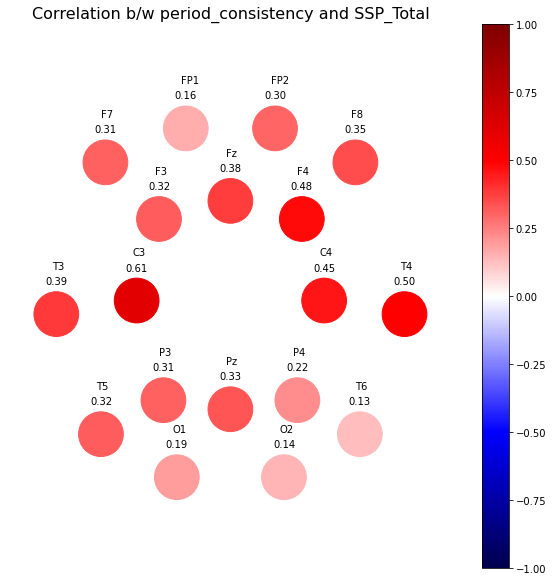

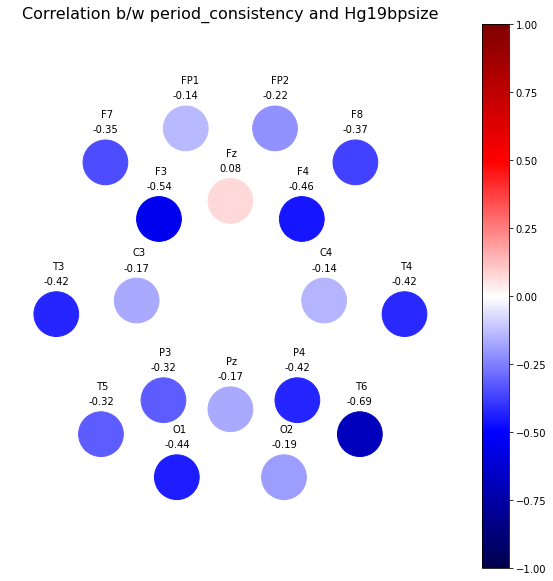

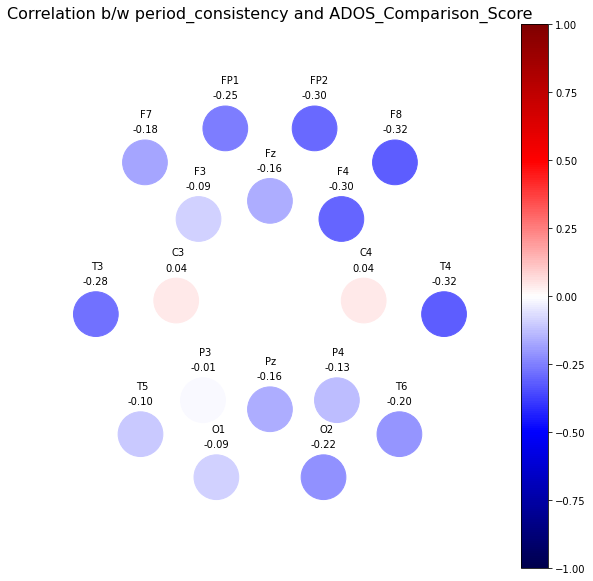

In [18]:
measure='period_consistency'
phenotype_demographics=['SSP_Total','Hg19bpsize','ADOS_Comparison_Score']

graph_topoplots_corr(phenotype_demographics,measure,bursts_only=0)

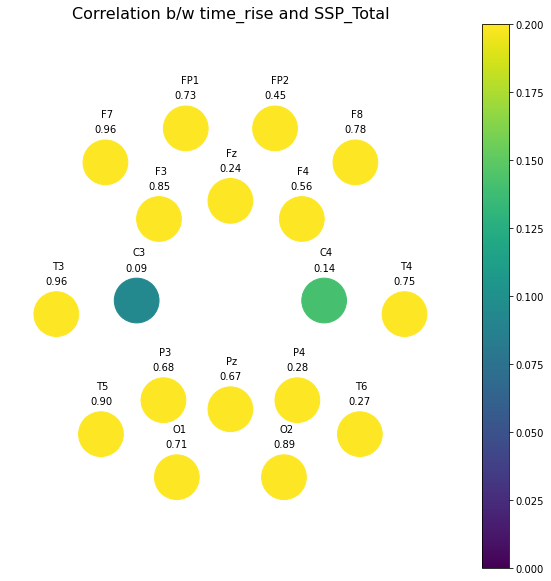

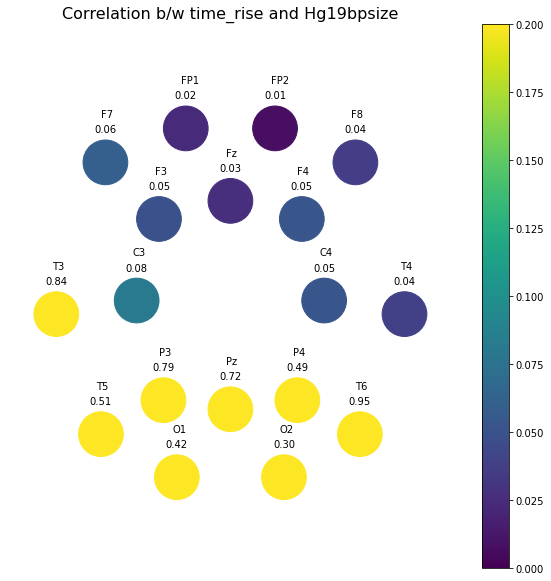

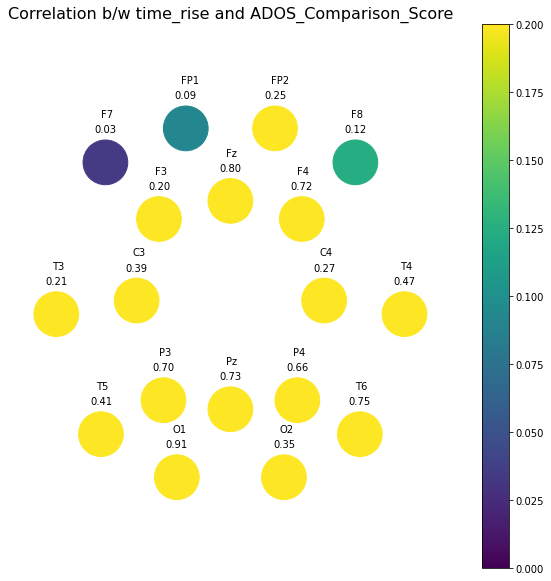

In [22]:
measure='time_rise'
phenotype_demographics=['SSP_Total','Hg19bpsize','ADOS_Comparison_Score']

graph_topoplots(phenotype_demographics,measure,bursts_only=0)

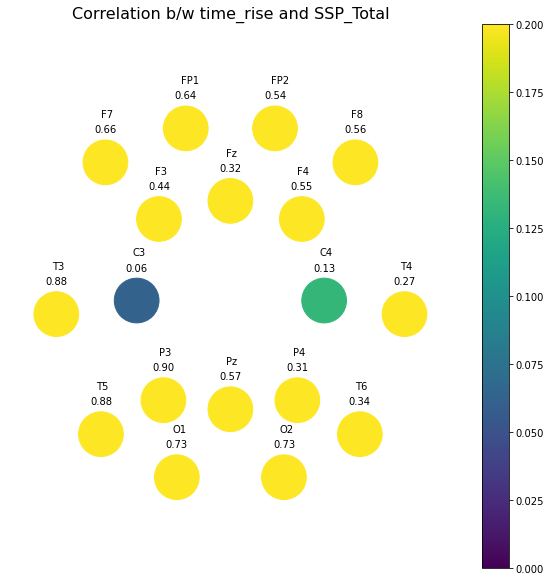

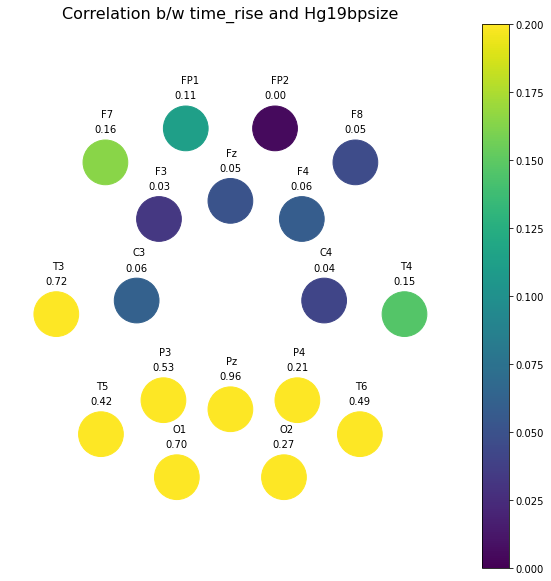

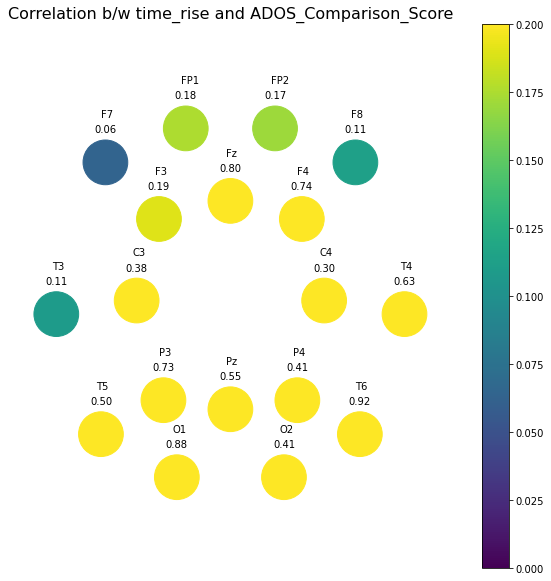

In [24]:
measure='time_rise'
phenotype_demographics=['SSP_Total','Hg19bpsize','ADOS_Comparison_Score']

graph_topoplots(phenotype_demographics,measure,bursts_only=1)

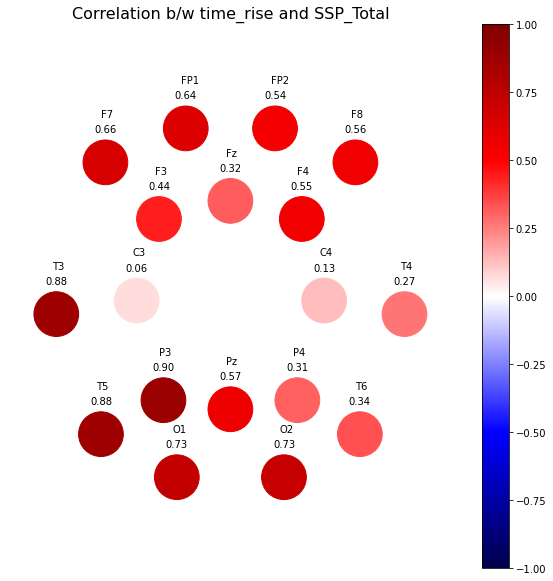

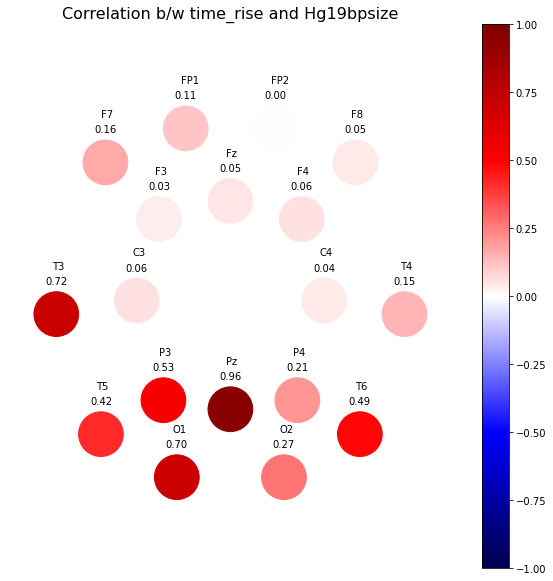

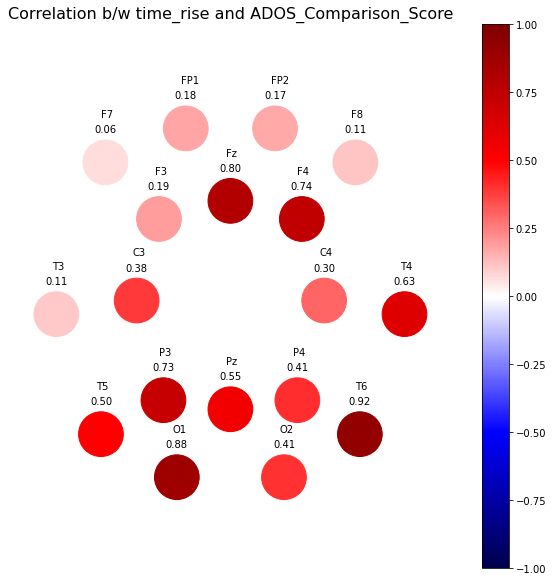

In [23]:
measure='time_rise'
phenotype_demographics=['SSP_Total','Hg19bpsize','ADOS_Comparison_Score']

graph_topoplots_corr(phenotype_demographics,measure,bursts_only=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


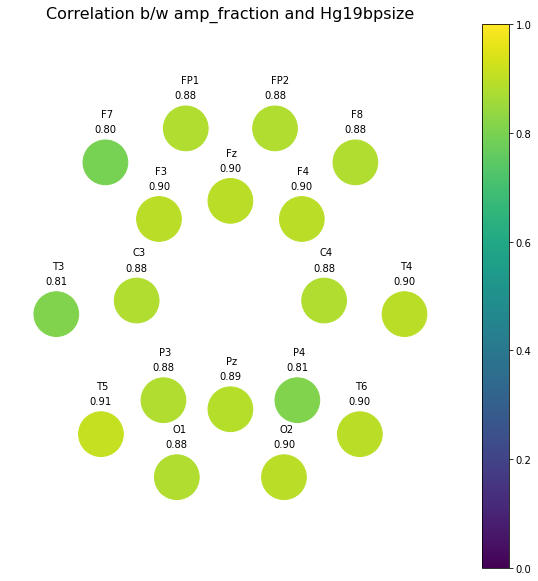

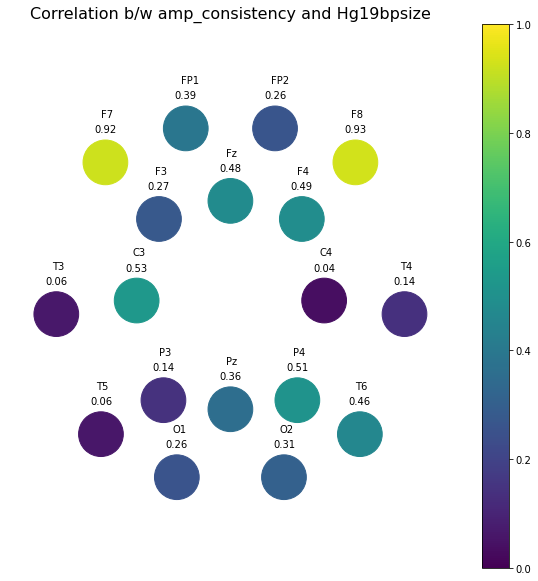

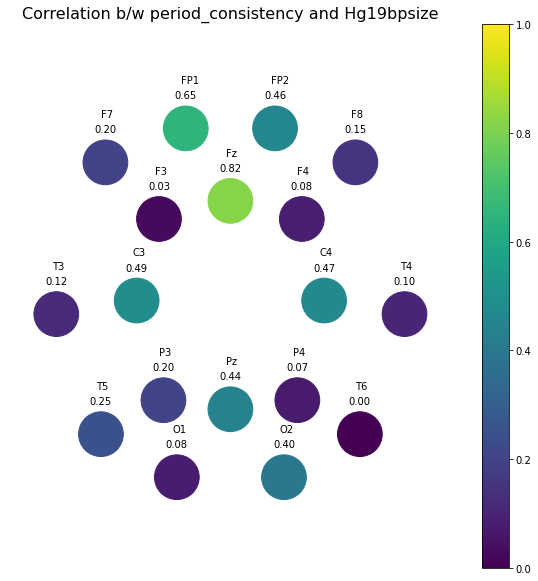

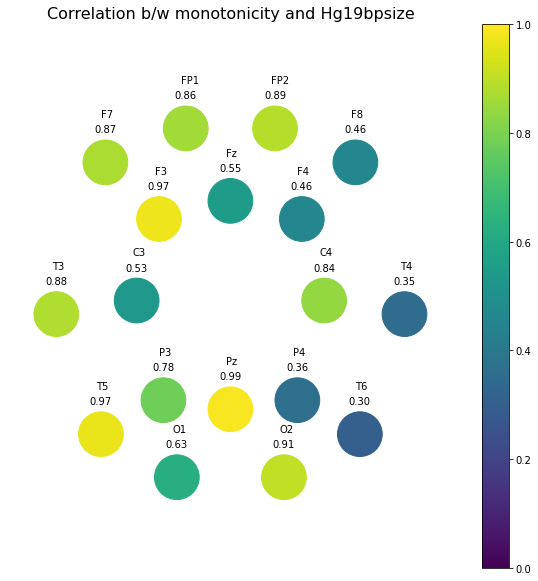

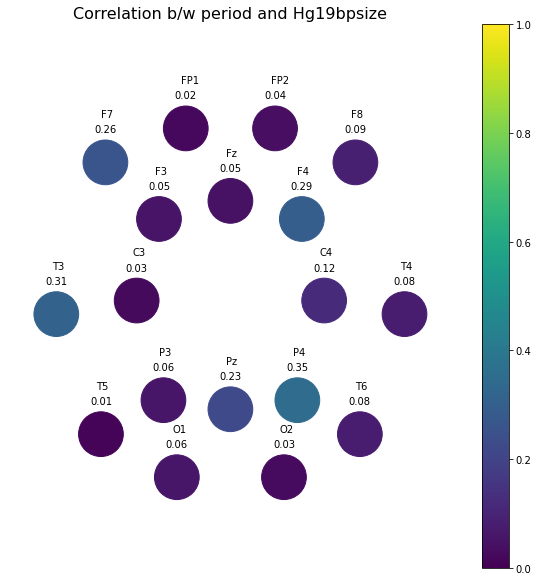

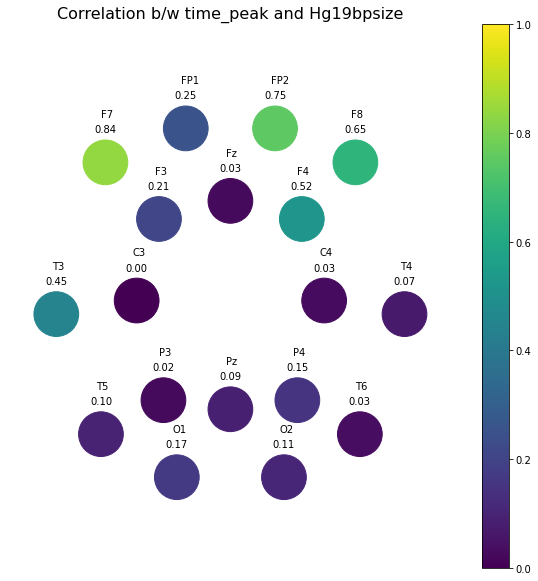

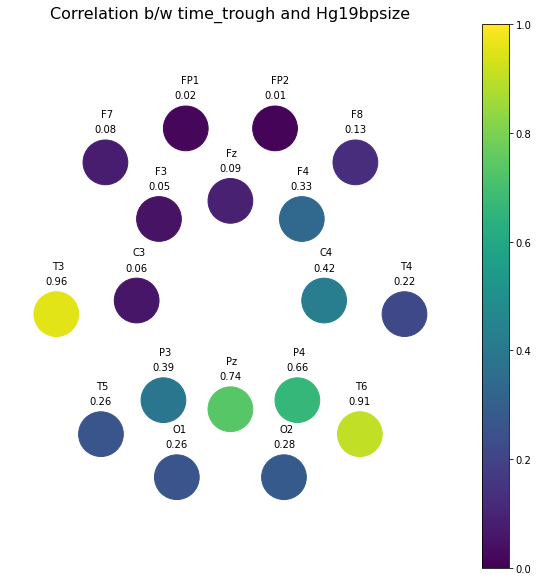

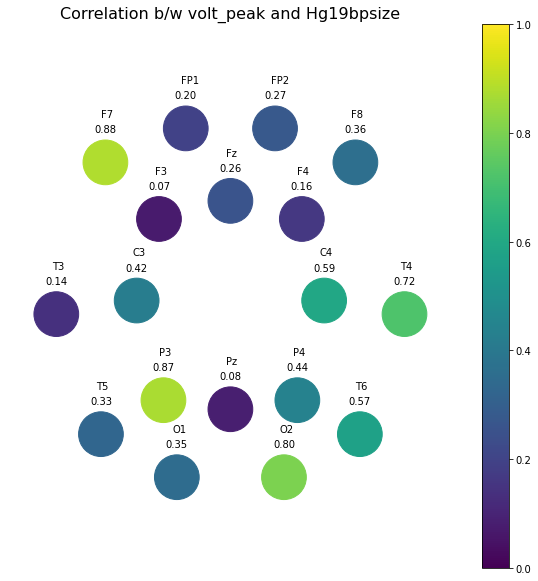

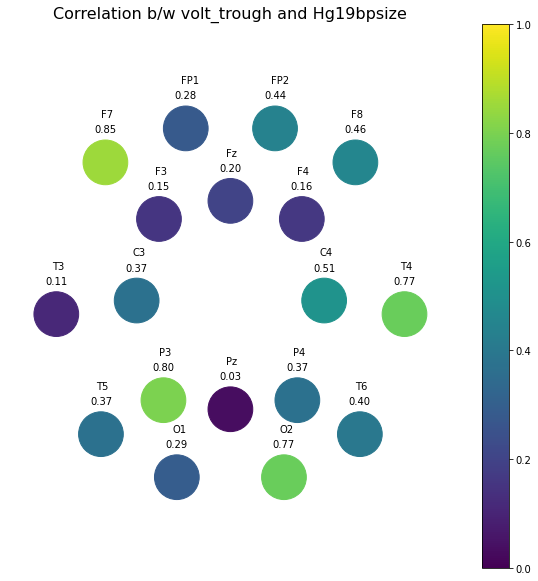

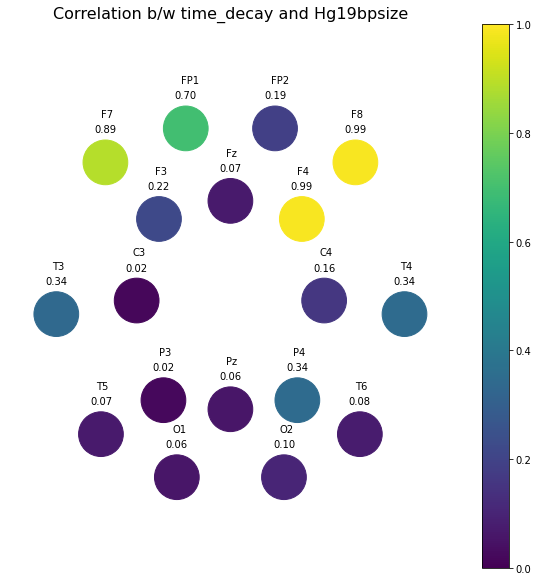

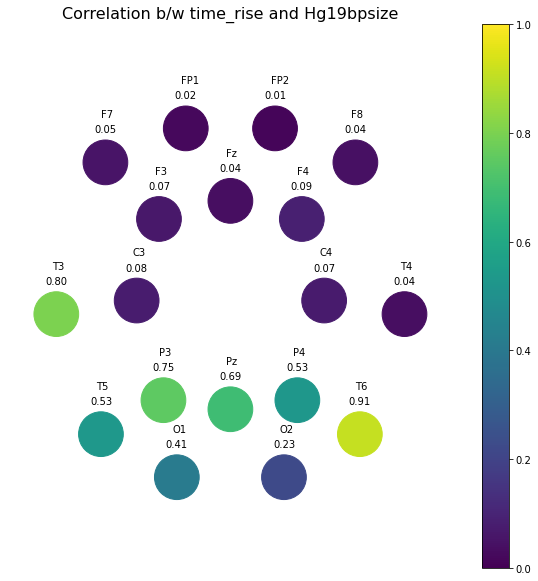

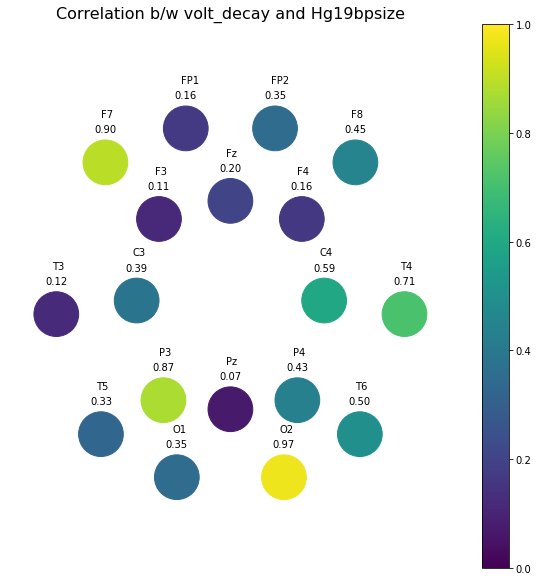

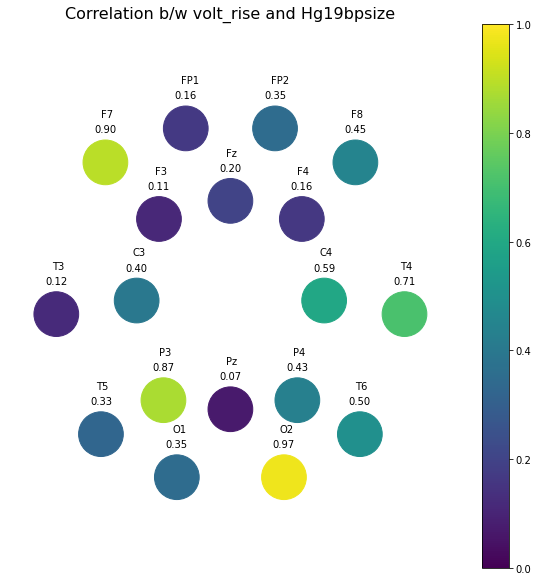

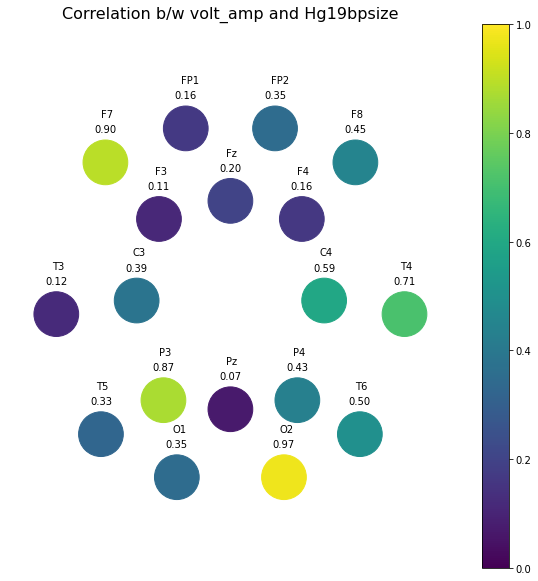

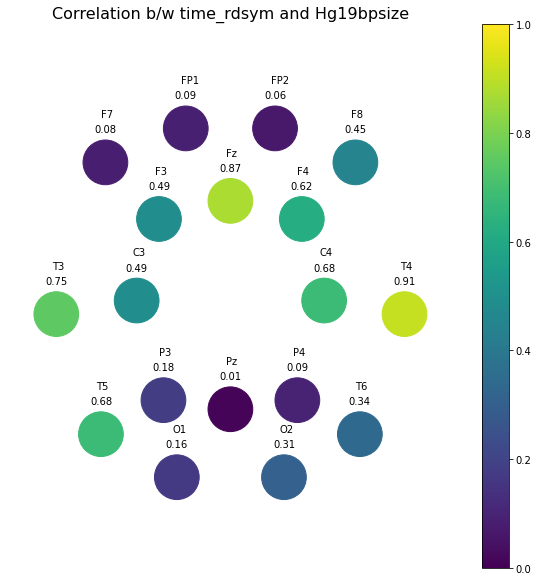

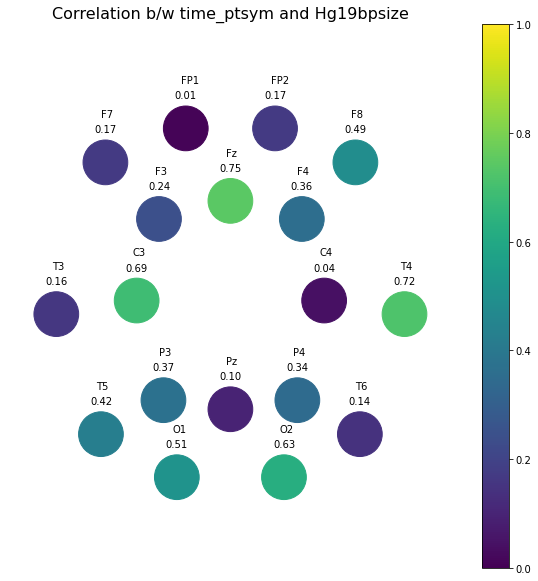

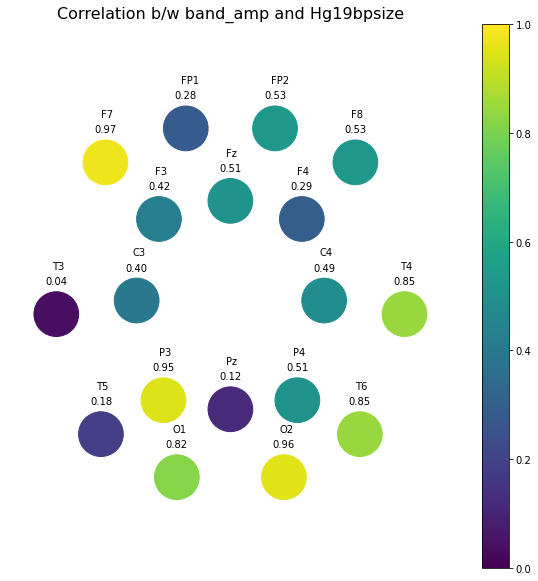

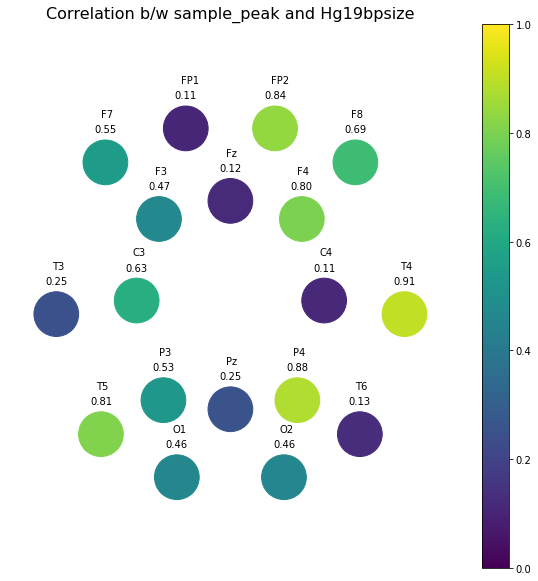

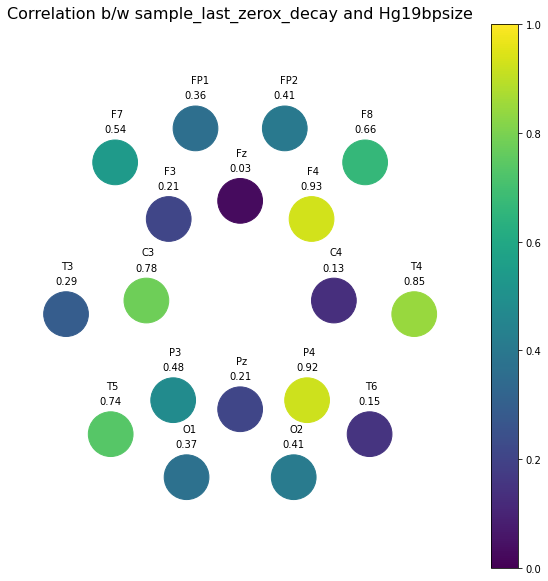

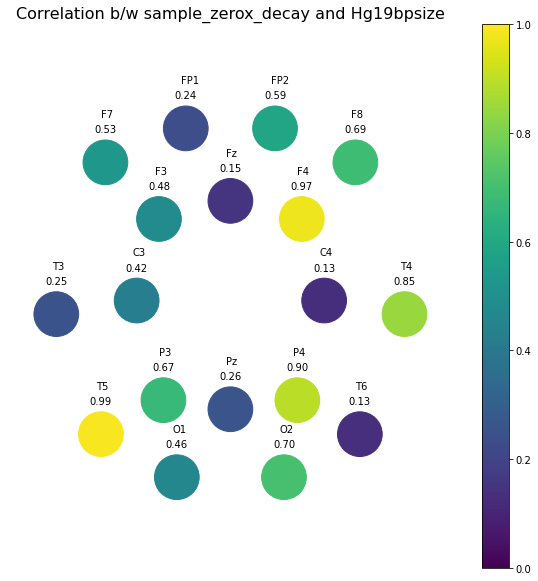

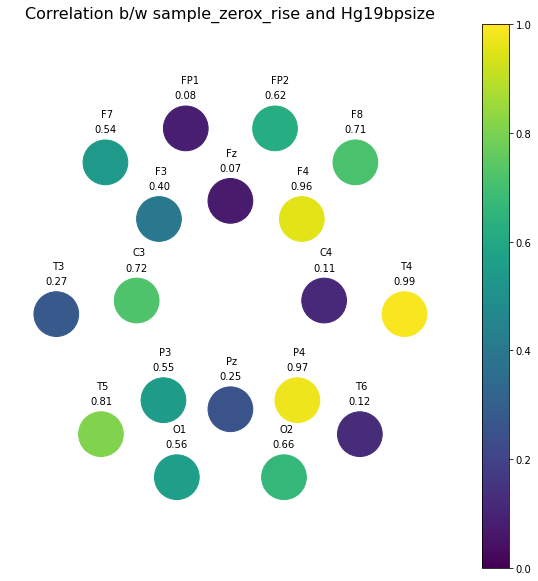

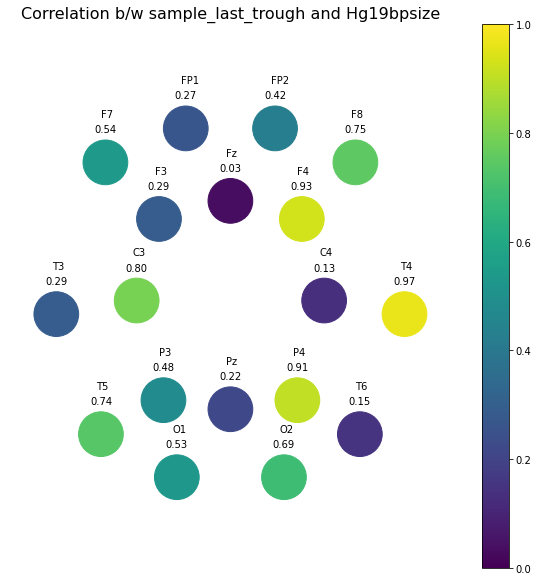

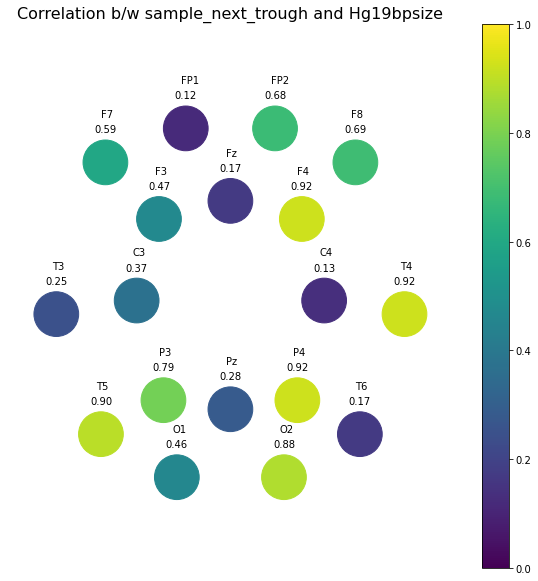

In [99]:
def graph_topoplots_across_bycycle(demographic,only_bursts=1):
     """graph topoplots for one demographic, correlated with all bycycle measures
    
    Parameters
    ----------
    -demographics: string, the demogrpahic measure to graph topoplots for
    -bursts_only: bool, default=True
        whether to account only for burst cycles or not
   
    """
    columns= ['amp_fraction', 'amp_consistency', 'period_consistency', 'monotonicity',
       'period',  'time_peak', 'time_trough', 'volt_peak', 'volt_trough',
       'time_decay', 'time_rise', 'volt_decay', 'volt_rise', 'volt_amp',
       'time_rdsym', 'time_ptsym', 'band_amp', 'sample_peak',
       'sample_last_zerox_decay', 'sample_zerox_decay', 'sample_zerox_rise',
       'sample_last_trough', 'sample_next_trough']
    
    channels=['FP1', 'FP2', 'F7', 'F3', 'F4', 'F8', 'C3', 'C4', 'T5',
       'Pz','T6','O1', 'O2', 'T3', 'T4', 'P3', 'P4', 'Fz']


    for measure in columns: #graph one for each measure
        topoplot_list=[]

        for ch in channels:   
            corre=find_correlations(ch,demographic)
             if bursts_only==1:    
                corr=(corre[corre['Feature']==measure]['Pvalue-burst only']).to_numpy() #get p value =strength of correlation
            else:
                corr=(corre[corre['Feature']==measure]['Pvalue']).to_numpy()
            topoplot_list.append(corr[0])
        #print(topoplot_list)   

        mini=0
        maxi=1

        #scatter plot axis locations
        ch_x = [4,6,2.2,3.4,6.6,7.8,2.9,7.1,2.1,5,7.9,3.8,6.2,1.1,8.9,3.5,6.5,5]
        ch_y = [8.7,8.7,7.95,6.7,6.7,7.95,4.9,4.9,1.95,2.5,1.95,1,1,4.6,4.6,2.7,2.7,7.1]

        fig,ax = plt.subplots()

        im = ax.scatter(ch_x, ch_y,s=2000,c=topoplot_list,vmin=mini,vmax=maxi)

        #add labels
        i=0
        for x,y in zip(ch_x,ch_y):
            label= '%.2f'%topoplot_list[i]
            i+=1
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,30), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

        fig.colorbar(im, ax=ax)
        ax.set_xlim([0,10])
        ax.set_ylim([-1,11])

        ax.axis('off')
        ax.set_title(('Correlation b/w '+measure+ ' and '+ demographic ),fontsize=16)

        fig.set_figheight(10)
        fig.set_figwidth(10)

        for i, txt in enumerate(channels):
            ax.annotate(txt, (ch_x[i] - 0.1, ch_y[i]+1))

        fig.savefig(('/Users/naomimiller/Documents/thesis_jhub/Topoplots_alpha/strenghthofcorr_'+measure+'-'+demographic+'.png'))

In [19]:
def plot_hists(path_name,channel,feature):
    """plots histograms for all participants in a foloder representing the spread 
    of a bycycle feature in a certain channel across all cycles in a participant's EEG recording
    also prints info about the standard deviation, standard error and mean of each histogram
    
    Parameters
    ----------
    -path_name: string, the folder where participant data is located
    -channel: string, must be one of keys in name_dict
    -feature: string, one of the 23 bycycle features
   
    Returns
    -------
    -pandas dataframe with rows for each bycycle measure, includes the correlation stats between the demographic measure 
    and each bycycle measure, for just burst cycles and all cycles
        columns='Feature','Correlation','Pvalue','Correlation-burst only', and 'Pvalue-burst only'
    
    Notes
    -----
    -using the pre-loaded tuples control, pms, control_bursts,pms_bursts
    """
    
    fs=250
    freq_range=(8,12)
    np.set_printoptions(threshold=np.inf)
    path = path_name
    files = [f for f in glob.glob(path + "**/*.mat", recursive=True)]
    fileNum=1
    
    for f in files:
    #initializing for average data for this participant
        name=os.path.basename(f).split('.mat')[0] #just participant number
        
        data=loadmat(f)
        #had to do this to be able to check by channel, will figure out mapping later
        eeg_data=data['eeg_w'][0][0]
        electrode_idx= data['file_proc_info']['net_10_20_elecs'][0][0][0]-1 #matlab to python idx
        netName=data['file_proc_info']['net_typ'][0][0][0][0][0]

        eeg_data=eeg_data[electrode_idx,:,:] #just 10_20 electrodes
        eeg_data=eeg_data.swapaxes(1,2) #channel by segment by timepoint
        #eeg_data.shape
        n_channels=len(eeg_data)
        n_epochs=len(eeg_data[0])

        thresholds = dict(amp_fraction_threshold=0., amp_consistency_threshold=.5, #using medians
                  period_consistency_threshold=.5, monotonicity_threshold=.5,
                  min_n_cycles=3)

        compute_kwargs = {'burst_method': 'cycles', 'threshold_kwargs': thresholds}

        #run bycycle
        dfs_rest = compute_features_3d(eeg_data, fs, freq_range, axis=0,
                                   compute_features_kwargs=compute_kwargs)
        #print(dfs_rest)
         #adding info about epochs and channels for organizing
        epoch_labels = ["Segment{ep_idx}".format(ep_idx=ep_idx) for ch_idx in range(n_channels) for ep_idx in range(n_epochs)]
        df_rest = flatten_dfs(dfs_rest, epoch_labels, 'Epoch')


        ch_labels = ["CH{ch_idx}".format(ch_idx=ch_idx+1) for ch_idx in electrode_idx for ep_idx in range(n_epochs)]
        df_channels = flatten_dfs(dfs_rest, ch_labels, 'Channel')

        true_channel=map_channel(netName,channel)
        individual=df_channels[df_channels['Channel']==true_channel][feature] 
        
        std_dev=np.std(individual)
        std_error=sem(individual,nan_policy='omit')
        
        mean=np.mean(individual)
        print(f'std_dev={std_dev}')
        print(f'std_error={std_error}')
        print(f'mean={mean}')
        print(f'n={len(individual)}')
        plt.figure()
        plt.hist(individual)
        plt.title(f'Participant {fileNum}: {feature} in {channel}')
        plt.xlabel('Value')
        plt.ylabel('Number of cycles')
        plt.show()
        fileNum=fileNum+1


std_dev=0.16297624496290003
std_error=0.0023841106993401444
mean=0.48749531518795314
n=4674


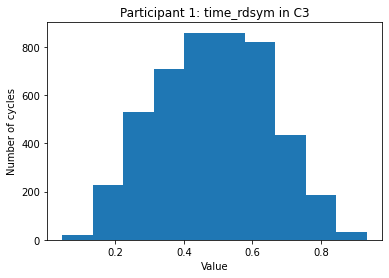

std_dev=0.17097884276841527
std_error=0.0022557831943126787
mean=0.4994389465533738
n=5746


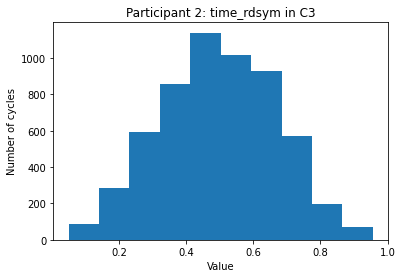

std_dev=0.16976129493902084
std_error=0.002476222984295184
mean=0.5050446593105121
n=4701


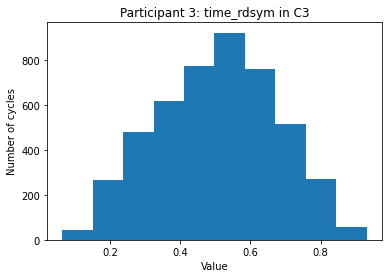

std_dev=0.17151208853645508
std_error=0.0023988291237054065
mean=0.5006725437689904
n=5113


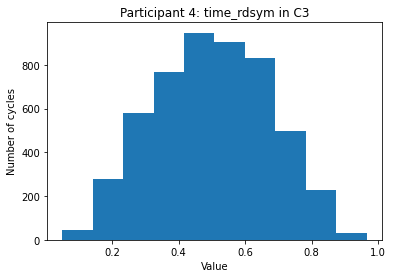

std_dev=0.16385459637227243
std_error=0.0021706880033571436
mean=0.4897457361942346
n=5699


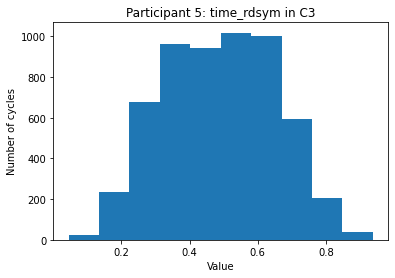

std_dev=0.1670636603874787
std_error=0.0023203286164927596
mean=0.4836986822291628
n=5185


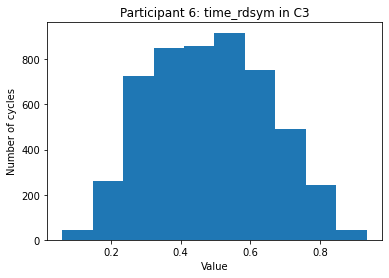

std_dev=0.17654393237834187
std_error=0.002750786599175689
mean=0.4951533969571143
n=4120


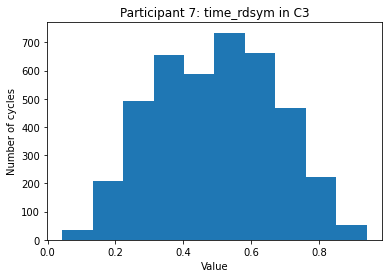

std_dev=0.167501676755112
std_error=0.0023967974347955806
mean=0.4942824708293671
n=4885


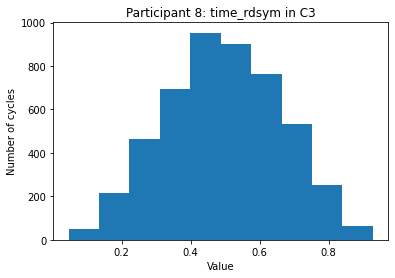

std_dev=0.164725999729932
std_error=0.002810598313227797
mean=0.4915807751131253
n=3436


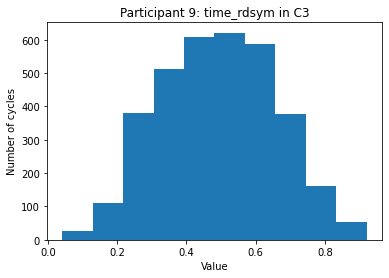

std_dev=0.16877803365937638
std_error=0.0021727675670791713
mean=0.49835104934776914
n=6035


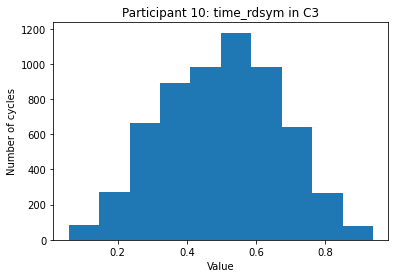

std_dev=0.1753473097160954
std_error=0.002138699919050762
mean=0.4962711311228476
n=6723


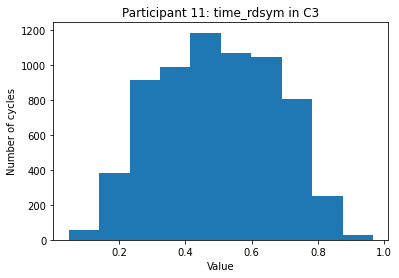

std_dev=0.16423338415722616
std_error=0.002648236713165699
mean=0.5009946207346195
n=3847


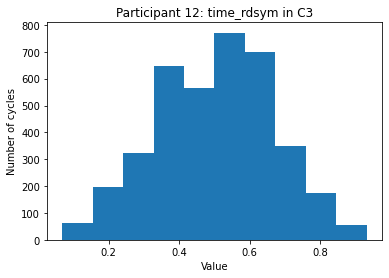

std_dev=0.1726086493037001
std_error=0.0022010251053871115
mean=0.49687927415718774
n=6151


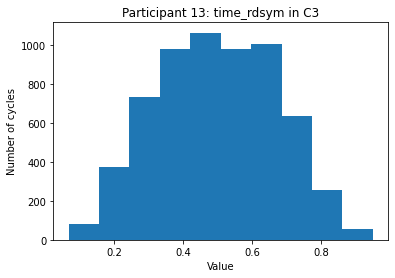

std_dev=0.16267625136668118
std_error=0.004361748206648293
mean=0.5006358522815294
n=1392


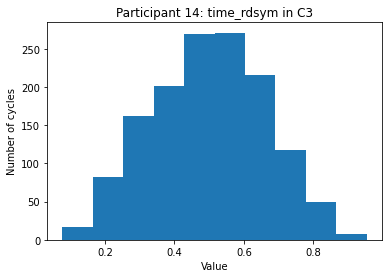

In [20]:
df=plot_hists('/Users/naomimiller/Documents/thesis_jhub/all_participants/control_participants','C3','time_rdsym')


BELOW: creating a simulation for statistical processing, making sure differences between groups were actually of note and not random due to signal processing or methodological errors

In [170]:
#this block was to create a list of participants with which to run the simulation (from both groups, 
#had to access both folders)
import os
import random
import shutil
import re

#created new directories to hold the simulated groups each time it was run
inside_dir='/Users/naomimiller/Documents/thesis_jhub/all_participants/simulation'
outside_dir='/Users/naomimiller/Documents/thesis_jhub/all_participants'

pms_sim='/Users/naomimiller/Documents/thesis_jhub/all_participants/PMS_sim'
control_sim='/Users/naomimiller/Documents/thesis_jhub/all_participants/control_sim'

all_participants=[]
all=os.listdir(inside_dir)
for f in all:
    if re.match('7905',f)!=None:
        all_participants.append(f)


In [173]:
#this section is to create dataframes with p-values and average differences between simulated groups
import matplotlib.pyplot as plt


measures=['period_consistency','time_rdsym','time_rise']
channels=['P3','P4','Pz','Fz','C3','C4','O1','O2']
df_pvals= pd.DataFrame(columns=['P3_period_consistency','P3_time_rdsym','P3_time_rise',
                                'P4_period_consistency','P4_time_rdsym','P4_time_rise',
                               'Pz_period_consistency','Pz_time_rdsym','Pz_time_rise',
                               'Fz_period_consistency','Fz_time_rdsym','Fz_time_rise',
                               'C3_period_consistency','C3_time_rdsym','C3_time_rise',
                               'C4_period_consistency','C4_time_rdsym','C4_time_rise',
                               'O1_period_consistency','O1_time_rdsym','O1_time_rise',
                               'O2_period_consistency','O2_time_rdsym','O2_time_rise',])

df_diff= pd.DataFrame(columns=['P3_period_consistency','P3_time_rdsym','P3_time_rise',
                                'P4_period_consistency','P4_time_rdsym','P4_time_rise',
                               'Pz_period_consistency','Pz_time_rdsym','Pz_time_rise',
                               'Fz_period_consistency','Fz_time_rdsym','Fz_time_rise',
                               'C3_period_consistency','C3_time_rdsym','C3_time_rise',
                               'C4_period_consistency','C4_time_rdsym','C4_time_rise',
                               'O1_period_consistency','O1_time_rdsym','O1_time_rise',
                               'O2_period_consistency','O2_time_rdsym','O2_time_rise',])

#run the simulation 100 times
for i in tqdm(range(100)):
    #clear folders for simulation to begin
    for file in os.listdir(pms_sim):
        if re.match('7905',file)!=None: #make sure only removing participants
            os.remove(os.path.join(pms_sim, file))

    for file in os.listdir(control_sim):
        if re.match('7905',file)!=None:
            os.remove(os.path.join(control_sim, file))
    
    #create random groups
    #first choose 14 random for control group
    sim_controls=[] 
    while len(sim_controls)<14:
        one=random.choice(all_participants)
        if (not one in sim_controls):
            if re.match('7905',one)!=None:
                sim_controls.append(one)
        
    #make the remaining 22 part of the "pms" group
    sim_pms=[]
    for file in all_participants:
        #print(file)
        if not file in sim_controls:
            if file!='.ipynb_checkpoints':
                #print(file)
                sim_pms.append(file)
 
    #move groups to simulation folders for run_a_group
    pms_group=os.path.join(outside_dir,'PMS_sim')
    control_group=os.path.join(outside_dir,'control_sim')

    for file in sim_controls:
        shutil.copy(os.path.join(inside_dir,file), control_group) 
    for file in sim_pms:
        shutil.copy(os.path.join(inside_dir,file), pms_group) 

    #run_a_group to do bycycle processing
    sim_control_avg=run_a_group(control_group,only_bursts=0,freq_range=(8,12))
    sim_pms_avg=run_a_group(pms_group,only_bursts=0,freq_range=(8,12))  
    all_pvals=find_all_significant(sim_control_avg,sim_pms_avg,columns='columns1')[0]
      
    #do kruskal wallace and differences on different channels/measures for histograms
    p_vals=[]
    differences=[]
    for channel in channels:
        for measure in measures:
            #isolate significance level for group difference, in this channel and this measure
            i=all_pvals.loc[(all_pvals['channel'] == channel) & (all_pvals['measure'] == measure)]
            #add the p value to greater dataframe
            p_vals.append(float(i['p val']))
            
            #find group avg differences
            control_measures=loop_through_dict(sim_control_avg,measure,channel)  
            pms_measures=loop_through_dict(sim_pms_avg,measure,channel)  
            diff=np.mean(pms_measures)-np.mean(control_measures)
            differences.append(diff)
            
    #create a larger dataframe with both p values and differences integrated      
    pval_series = pd.Series(p_vals, index = df_pvals.columns)
    df_pvals=df_pvals.append(pval_series, ignore_index=True)  
    
    diff_series=pd.Series(differences, index = df_diff.columns)
    df_diff=df_diff.append(diff_series, ignore_index=True)

#save the dataframes with simulation p values and group differences
df_diff.to_pickle('/Users/naomimiller/Documents/thesis_jhub/simulation_4_differences')
df_pvals.to_pickle('/Users/naomimiller/Documents/thesis_jhub/simulation_4_pvals')


100%|██████████| 100/100 [7:04:22<00:00, 254.63s/it] 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


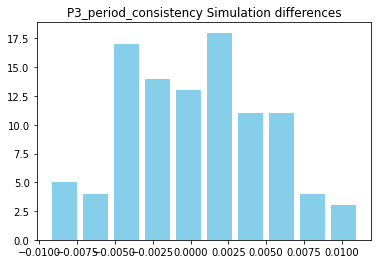

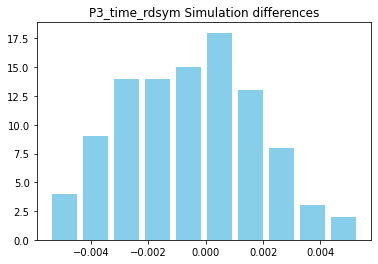

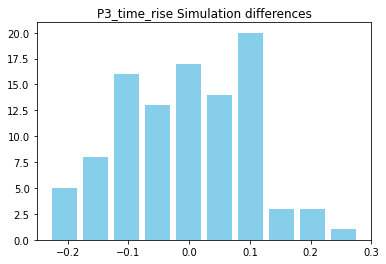

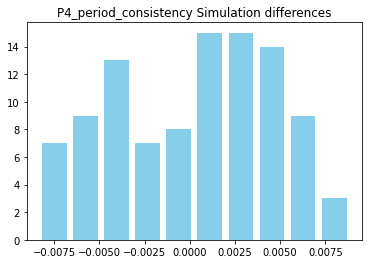

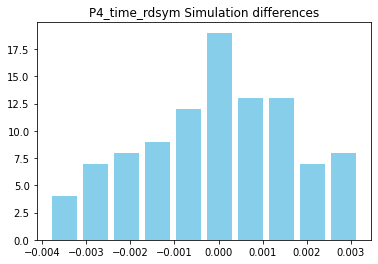

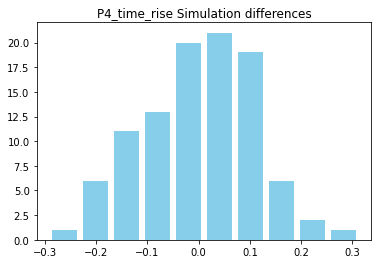

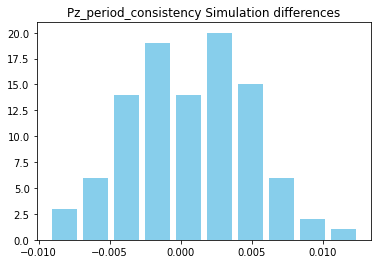

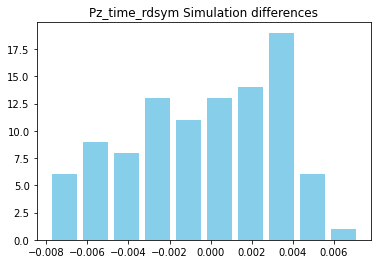

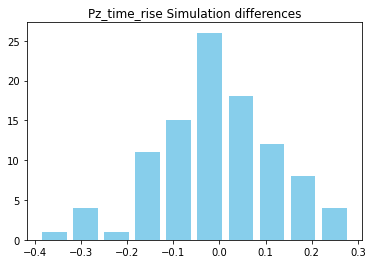

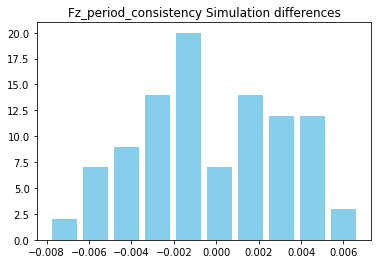

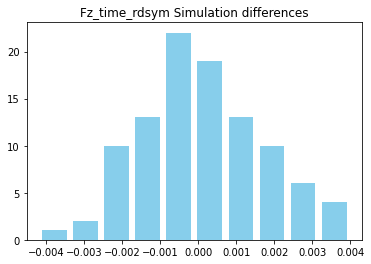

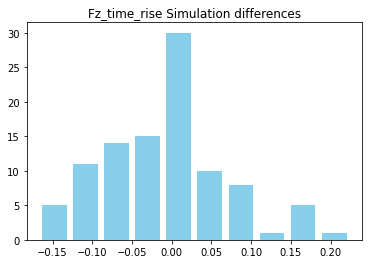

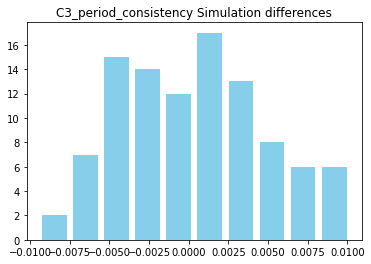

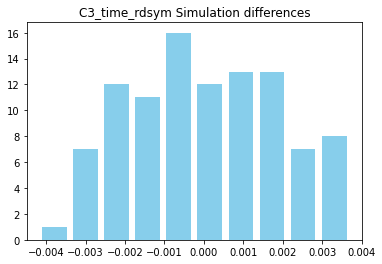

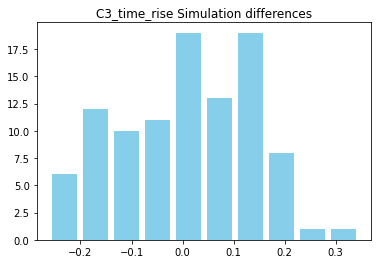

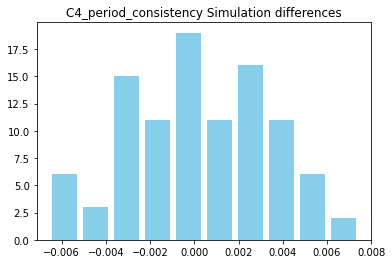

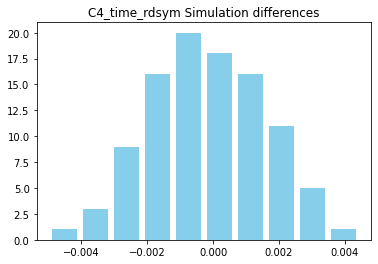

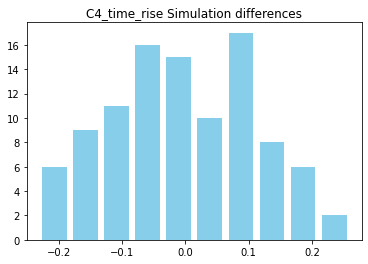

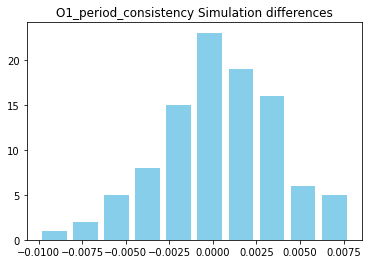

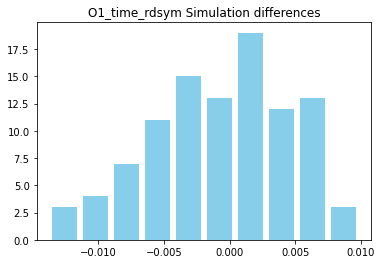

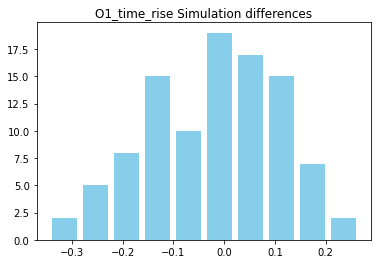

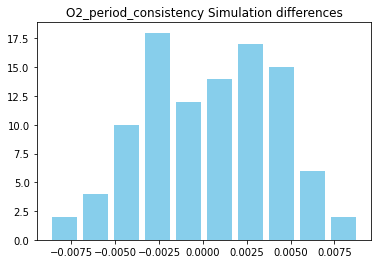

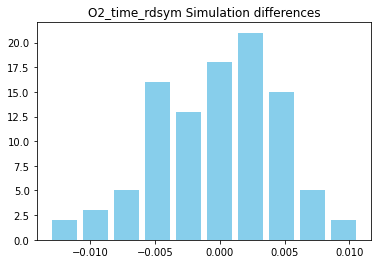

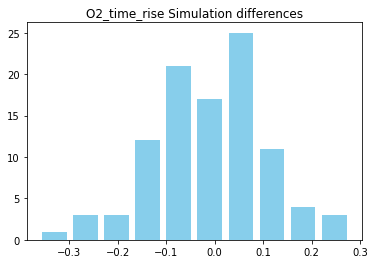

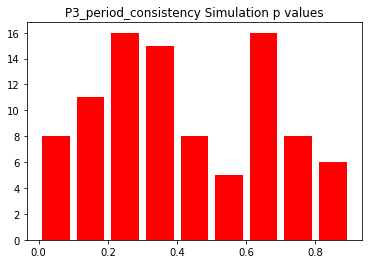

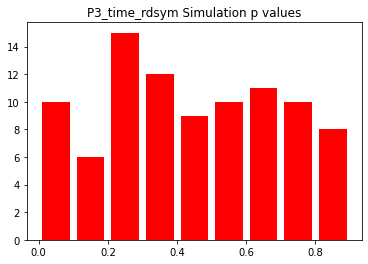

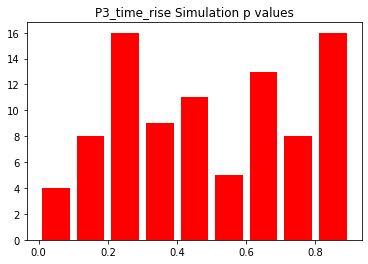

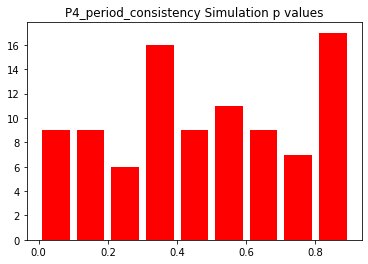

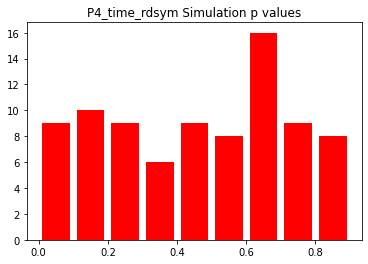

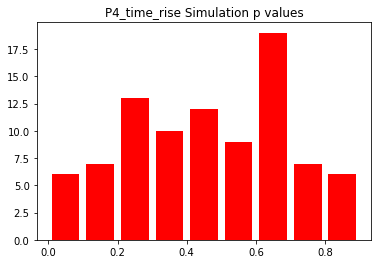

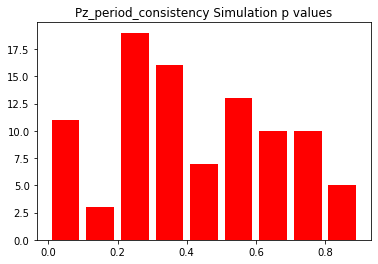

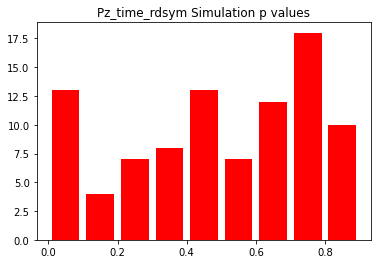

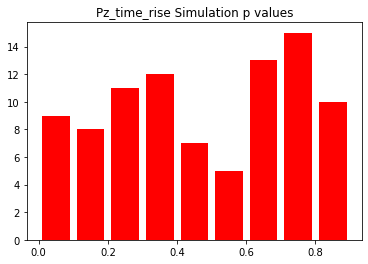

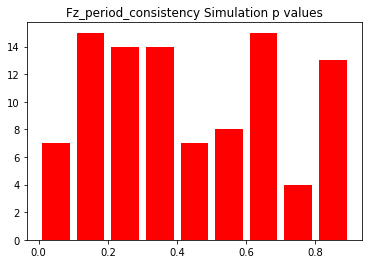

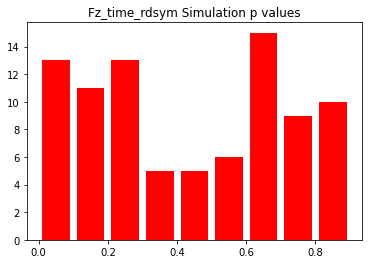

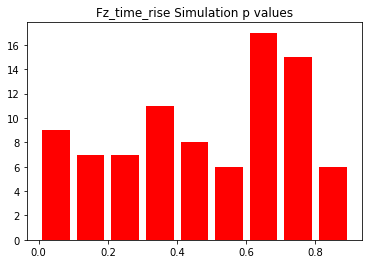

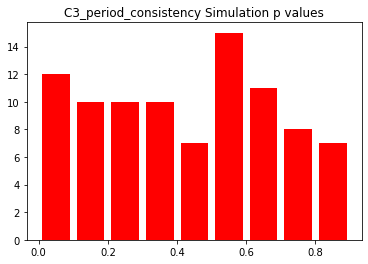

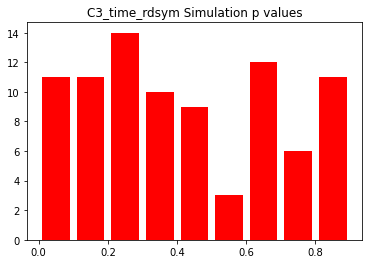

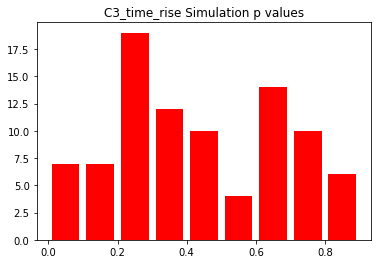

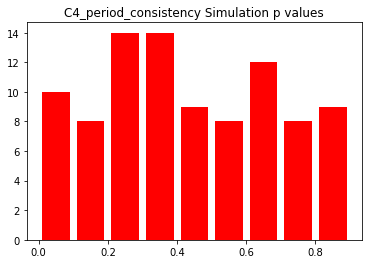

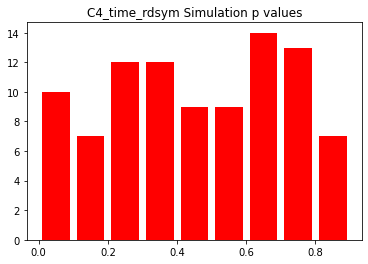

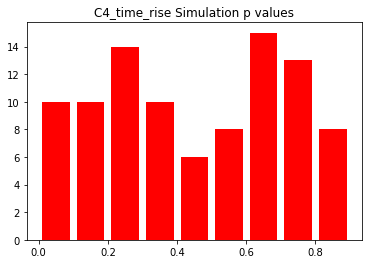

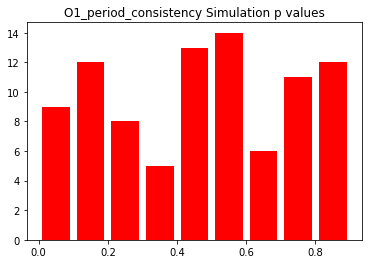

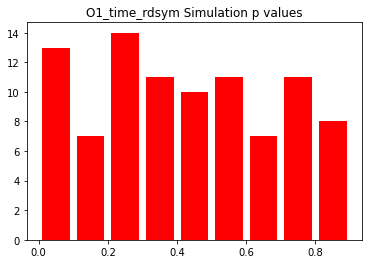

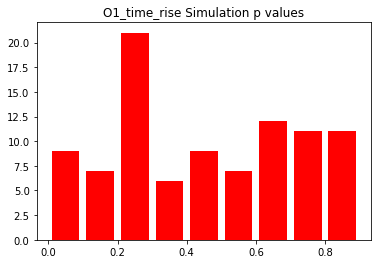

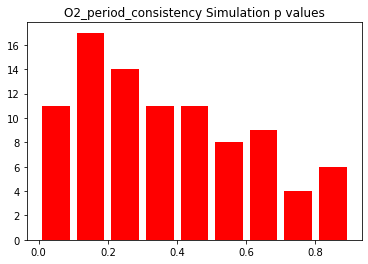

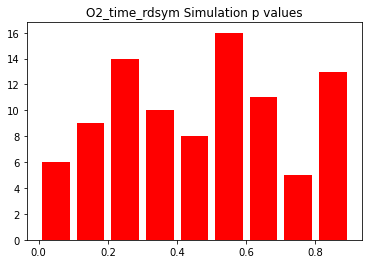

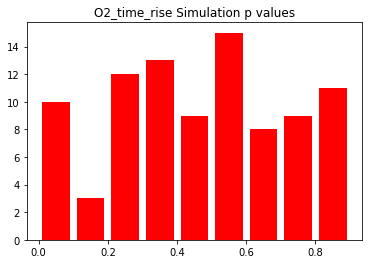

In [33]:
#load the pre-saved dataframes with p values and differences
import pickle
with open('/Users/naomimiller/Documents/thesis_jhub/simulation_4_differences', "rb" ) as f:
    df_diff = pickle.load(f)
with open('/Users/naomimiller/Documents/thesis_jhub/simulation_4_pvals', "rb" ) as f:
    df_pvals = pickle.load(f)

#plot simulation histograms
for column in df_diff.columns:
    plt.figure()
    plt.title(f'{column} Simulation differences')
    plt.hist(df_diff[column],rwidth=0.8,color= "skyblue")    
    
for column in df_pvals.columns:
    plt.figure()
    plt.title(f'{column} Simulation p values')
    bins=np.arange(0,1,.1)
    plt.hist(df_pvals[column],rwidth=0.8,color="red",bins=bins)   
    

For future use: plotting segments' cycles

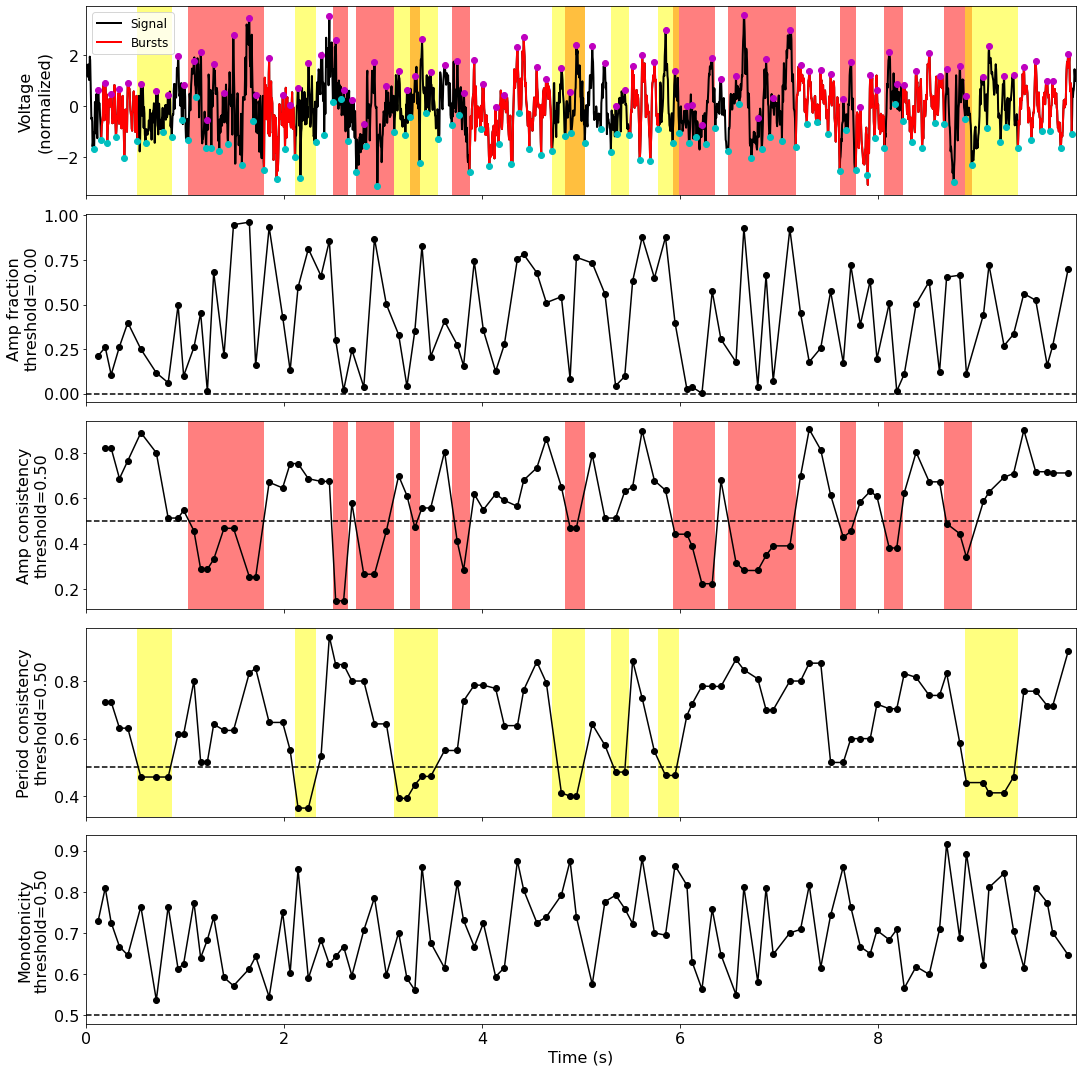

In [155]:
thresholds = dict(amp_fraction_threshold=0., amp_consistency_threshold=.5, #using medians
                  period_consistency_threshold=.5, monotonicity_threshold=.5,
                  min_n_cycles=3)
fs=250

#example participant
data=loadmat('/Users/naomimiller/Documents/thesis_jhub/PMS_segment_1-31-2021/7905-01-0010-rest-v1.mat')
eeg_data=data['eeg_w'][0][0]
electrode_idx= data['file_proc_info']['net_10_20_elecs'][0][0][0]-1 #matlab to python idx
        
eeg_data=eeg_data[electrode_idx,:,:] #just 10_20 electrodes
eeg_data=eeg_data.swapaxes(1,2) #channel by segment by timepoint
compute_kwargs = {'burst_method': 'cycles', 'threshold_kwargs': thresholds}

dfs_rest = compute_features_3d(eeg_data, fs, (8,12), axis=0,
                                   compute_features_kwargs=compute_kwargs,return_samples=True)

#plot one participant, first channel, one segment
plot_burst_detect_summary(dfs_rest[0][0],eeg_data[0][0],fs,threshold_kwargs=thresholds)